In [642]:
# Appending the directory containing your `python_startup` file, with credentials filled out

import sys
sys.path.append('/Users/Myers/Documents/GitHub/myers2022/Python/Jupyter/python_startup.py')
from python_startup import * 

from tqdm import tqdm
from collections import Counter

## Get uPNs

In [643]:
#from neuprint import NeuronCriteria as NC
#criteria = NC(type='DA2_lPN')
  
#Better to generalise to all uPNs for now to make normalisation simpler

uPN_df = pd.read_csv('FIB_uPNS.csv')

In [644]:
from neuprint import fetch_neurons
uPN_df, uPN_roi_counts_df = fetch_neurons(uPN_df.bodyid)

In [5]:
#uPN_df[['bodyId', 'instance', 'type', 'pre', 'post', 'status', 'cropped', 'size']]

## Retrieving downstream cells with synapses in the LH

In [645]:
uPN_bids = uPN_df.bodyId.tolist()

In [646]:
from neuprint import fetch_adjacencies, NeuronCriteria as NC

# Example: Fetch all direct connections between a set of upstream neurons and downstream neurons
uPN_lh_neuron_df, uPN_lh_conn_df = fetch_adjacencies(uPN_bids, NC(rois=['LH(R)']))

In [8]:
#uPN_lh_conn_df.sort_values('weight', ascending=False)

In [647]:
from neuprint import merge_neuron_properties

uPN_lh_conn_df = merge_neuron_properties(uPN_lh_neuron_df, uPN_lh_conn_df, ['type', 'instance'])
#uPN_lh_conn_df.sort_values('weight', ascending=False)

In [403]:
len(uPN_lh_conn_df)

31919

In [404]:
#Why have non LH rois been introduced here? 

### Removing axo-axonic PN connectivity in the LH

In [648]:
uPN_lh_conn = uPN_lh_conn_df[~uPN_lh_conn_df.bodyId_post.isin(uPN_df.bodyId.tolist())]

In [406]:
len(uPN_lh_conn.bodyId_post.unique())

2864

In [407]:
len(uPN_lh_conn_df.bodyId_post.unique())

2994

## Filtering the LHNs list, finding those with majority of postsynapses in the LH, and excluding LHLNs, keeping the analysis cholinergic

In [410]:
#Not entirely sure what we've got by using the LH(R) roi for this filtering process. Maybe we should be 
#using something else instead?
#For example, how would we remove LHLNs? By the number of outputs they have within the LH? There is a lot more 
#filtering to do here because there is all kinds of crap. One obvious answer is to filter by number of 
#connections...just remove all the single synapses between types? 

#How about, as Philipp mentions, using fetch_neurons() to get some info on 
#whether these neurons have the majority of their postsynapses in the LH. Or we could just use Alex's 
#LHN list from R, imported in the same way we did with the DNs. 

# So really we want polarised neurons, in which case we should use Philipp's approach of fetching neurons, 
# then filtering the LHN list by those with a majority of their synapses in the LH. Let's try that immediately below

In [649]:
#Fetch all of the downstream neurons
from neuprint import fetch_neurons

uPN_ds = uPN_lh_conn.bodyId_post.unique()
uPN_ds_df, uPN_ds_roi_counts_df = fetch_neurons(uPN_ds)

In [13]:
#Let's filter uPN_ds_roi_counts_df for those with an acceptable number of total postsynapses, OR BY TOTAL SYNAPSES? 
#Actually, we should filter by sum of postynapses for each roi, so it would be better done below

#uPN_ds_roi_counts_df = uPN_ds_roi_counts_df[uPN_ds_roi_counts_df['post'] > 50]
#uPN_ds_roi_counts_df.head(20)

In [14]:
#LH_roi = uPN_ds_roi_counts_df.groupby(['bodyId']).apply(lambda x: x.sort_values('post'))
#LH_roi.head(20)

In [409]:
uPN_ds_roi_counts_df

,bodyId,roi,pre,post
0,263674097,SNP(R),121,330
1,263674097,SMP(R),93,252
2,263674097,SIP(R),28,72
3,263674097,LH(R),10,184
4,263674097,SLP(R),0,6
...,...,...,...,...
21067,7112613651,LH(R),2,4
21068,7112613899,LH(R),3,2
21069,7112622144,LH(R),0,11
21070,7112623352,LH(R),2,12


In [650]:
#Now filter to remove bodyIds whose post column sums to less than, say, 20
LHN_filt = uPN_ds_roi_counts_df.groupby('bodyId').filter(lambda x : x['post'].sum() > 20)
#LHN_filt.head()

In [651]:
#Adding a new transformed column
LHN_filt['%'] = LHN_filt.groupby('bodyId')['post'].transform(
  lambda x: x/sum(x)*100
)
LHN_filt.head(20)

,bodyId,roi,pre,post,%
0,263674097,SNP(R),121,330,36.303630
1,263674097,SMP(R),93,252,27.722772
2,263674097,SIP(R),28,72,7.920792
3,263674097,LH(R),10,184,20.242024
4,263674097,SLP(R),0,6,0.660066
5,263674097,INP,1,25,2.750275
6,263674097,SCL(R),1,18,1.980198
7,263674097,CRE(R),0,7,0.770077
8,263674097,"CRE(-ROB,-RUB)(R)",0,7,0.770077
9,263674097,VLNP(R),0,4,0.440044


In [603]:
p = LHN_filt.groupby('bodyId')['post']
p

In [652]:
#Filter by ROI and percent of pre/post-synapses in that ROI...
LHNs = LHN_filt[(LHN_filt['roi']=='LH(R)') & (LHN_filt['%']>20)]
LHNs.sort_values('%', ascending = False).head(10)

,bodyId,roi,pre,post,%
13876,944055652,LH(R),154,167,100.0
4932,511267220,LH(R),103,118,100.0
14087,948131152,LH(R),0,21,100.0
14413,979196865,LH(R),0,25,100.0
9542,697456597,LH(R),175,288,100.0
8770,665735597,LH(R),396,722,100.0
6250,572642334,LH(R),136,232,100.0
2366,417186612,LH(R),123,221,100.0
9553,697801711,LH(R),95,163,100.0
11920,792610827,LH(R),103,175,100.0


In [653]:
#This seems to suggest that there are loads of cells with all of their postsynapses in the LH...can we find those in the original dataframe above?
len(LHN_filt[LHN_filt['%'] == 100])

93

In [656]:
LH_ds = LHNs['bodyId'].astype(np.int64)
LH_ds = LH_ds.to_list()

From here could either filter the column of uPN_lh_conn to remove anything not in LH_ds, then just proceed from there

In [657]:
#filter(bodyid.post) by is in LH_ds...or something along those lines
uPN_lh_filt = uPN_lh_conn[uPN_lh_conn['bodyId_post'].isin(LH_ds)]
uPN_lh_filt.sort_values('weight', ascending = False).head(10)

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
332,542634818,728483069,LH(R),148,DM1_lPN,DM1_lPN_R,LHAV4a1_b,LHAV4a1_b_R
711,544021095,574377845,LH(R),135,DA4l_adPN,DA4l_adPN_R,LHAV3f1,LHAV3f1_R
28,542634818,359214479,LH(R),134,DM1_lPN,DM1_lPN_R,LHCENT12,LHCENT12_R
35,542634818,359891881,LH(R),134,DM1_lPN,DM1_lPN_R,LHCENT12,LHCENT12_R
3571,635062078,478613576,LH(R),131,DP1m_adPN,DP1m_adPN_R,LHPD5c1,LHPD5c1_R
8338,724816115,5813048298,LH(R),117,DP1l_adPN,DP1l_adPN_R,LHPV4a7_c,LHPV4a7_c_R
148,542634818,480577749,LH(R),116,DM1_lPN,DM1_lPN_R,LHPD3a3_c,LHPD3a3_c_R
178,542634818,511616870,LH(R),116,DM1_lPN,DM1_lPN_R,LHPD3a3_b,LHPD3a3_b_R
31001,5813069089,696126258,LH(R),115,VL2a_adPN,VL2a_adPN_R,LHAV2m1,LHAV2m1_R
28168,5813050727,478613576,LH(R),113,VM7d_adPN,VM7d_adPN_R,LHPD5c1,LHPD5c1_R


In [613]:
#Comparing filtered df with original
uPN_lh_conn.sort_values('weight', ascending = False).head(10)

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
24649,1977579449,1700307582,AL(R),162,VA2_adPN,VA2_adPN_R,M_l2PNl21,M_l2PNl21_R
884,573333835,328861282,LH(R),148,DM4_adPN,DM4_adPN_R,LHCENT1,LHCENT1_R
332,542634818,728483069,LH(R),148,DM1_lPN,DM1_lPN_R,LHAV4a1_b,LHAV4a1_b_R
711,544021095,574377845,LH(R),135,DA4l_adPN,DA4l_adPN_R,LHAV3f1,LHAV3f1_R
35,542634818,359891881,LH(R),134,DM1_lPN,DM1_lPN_R,LHCENT12,LHCENT12_R
28,542634818,359214479,LH(R),134,DM1_lPN,DM1_lPN_R,LHCENT12,LHCENT12_R
3571,635062078,478613576,LH(R),131,DP1m_adPN,DP1m_adPN_R,LHPD5c1,LHPD5c1_R
3689,635062078,604709727,LH(R),128,DP1m_adPN,DP1m_adPN_R,LHPV10b1,LHPV10b1_R
3707,635062078,610274046,AL(R),124,DP1m_adPN,DP1m_adPN_R,M_vPNml50,M_vPNml50_R
8338,724816115,5813048298,LH(R),117,DP1l_adPN,DP1l_adPN_R,LHPV4a7_c,LHPV4a7_c_R


In [658]:
len(uPN_lh_conn.type_post.unique())

1137

In [659]:
len(uPN_lh_filt.type_post.unique())

537

In [660]:
len(uPN_lh_conn.type_post)

29965

In [661]:
len(uPN_lh_filt.type_post)

20767

### Looks like our filtering for those cells with more than 20% of their postsynpapses in the LH has massively reduced our list of downstreams. 

It would be interesting to compare the outcomes from here...but I suppose it shouldn't make that much difference, other than to remove some strange shortcuts or other types of circuit that we're not looking to compare (though still haven't convinced myself that this is a useful distinction or not). 

So from here we can uPN_lh_filt as the more stringent list of LHNs, and uPN_lh_conn for the whole lot

In [330]:
#If we're going to filter by synapse weight it needs to happen here...the problem with doing this by bodyId is that the weight by type might sum to 5
#and therefore become relevant. We could collapse to types, then filter by weight, then bring back the bodyIds of the cells that pass that? Otherwise
#just remove any individual cell with fewer than 5 connections? How much does that affect the outcome? 

In [111]:
#Here we just filter the bodyId weights
#uPN_lh_filt = uPN_lh_filt[uPN_lh_filt.weight > 5]
#uPN_lh_filt.head(10)

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
5,542634818,297921527,LH(R),7,DM1_lPN,DM1_lPN_R,LHAV6a3_a,LHAV6a3_a_R
8,542634818,327499164,CA(R),29,DM1_lPN,DM1_lPN_R,LHCENT2,LHCENT2_R
9,542634818,327499164,LH(R),27,DM1_lPN,DM1_lPN_R,LHCENT2,LHCENT2_R
18,542634818,329210713,LH(R),13,DM1_lPN,DM1_lPN_R,LHAD3f1_a,LHAD3f1_a_R
19,542634818,329211098,LH(R),19,DM1_lPN,DM1_lPN_R,LHAV6a3_a,LHAV6a3_a_R
22,542634818,329220439,LH(R),34,DM1_lPN,DM1_lPN_R,LHPV5d1_a,LHPV5d1_a_R
28,542634818,359214479,LH(R),134,DM1_lPN,DM1_lPN_R,LHCENT12,LHCENT12_R
30,542634818,359223830,LH(R),6,DM1_lPN,DM1_lPN_R,LHPV4d6,LHPV4d6_R
33,542634818,359560118,LH(R),7,DM1_lPN,DM1_lPN_R,LHAV2k4,LHAV2k4_R
35,542634818,359891881,LH(R),134,DM1_lPN,DM1_lPN_R,LHCENT12,LHCENT12_R


In [ ]:
#Here we collapse into types, filter by weight, then recreate the original table with the list of BodyIds that survive the 'type' cull

## Make a matrix of uPNs to LHNs

In [605]:
#First let's make a matrix

from neuprint.utils import connection_table_to_matrix

uPN_lh_matrix = connection_table_to_matrix(uPN_lh_conn, 'type', sort_by='type')
uPN_lh_matrix
uPN_lh_matrix.fillna(0)

type_post,AL-MBDL1,ALIN3,AOTU043,APL,AVLP003,AVLP010,AVLP012,AVLP013,AVLP014,AVLP015,...,aSP-f3,aSP-g2,aSP-g3A,mAL4,mAL6,mALB1,mALB2,mALB3,mALB4,NaN
type_pre,,,,,,,,,,,,,,,,,,,,,
DA1_lPN,0,0,0,117,0,4,7,4,0,0,...,1,37,0,0,0,17,0,0,0,0.0
DA1_vPN,0,0,0,1,0,0,0,0,0,13,...,0,2,0,0,0,0,0,0,0,0.0
DA2_lPN,0,0,0,25,0,0,0,0,0,0,...,2,0,0,0,0,1,0,0,0,0.0
DA3_adPN,0,0,0,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
DA4l_adPN,0,0,0,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM5v_adPN,0,0,0,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
VM7d_adPN,0,0,0,17,0,0,0,0,0,0,...,44,4,0,7,0,0,0,0,0,0.0
VM7v_adPN,6,0,0,10,0,0,0,0,0,0,...,2,9,1,0,0,0,0,0,0,0.0


In [662]:
#Here is the alternative with the more stringent LH downstream filtering

from neuprint.utils import connection_table_to_matrix

uPN_lh_matrix_filt = connection_table_to_matrix(uPN_lh_filt, 'type', sort_by='type')
uPN_lh_matrix_filt
uPN_lh_matrix_filt.fillna(0)

type_post,LC43,LHAD1a1,LHAD1a2_b,LHAD1a2_c,LHAD1a3,LHAD1a4_a,LHAD1a4_b,LHAD1b2_a,LHAD1b2_b,LHAD1b2_c,...,M_vPNml86,M_vPNml89,PLP068,SLP018,SLP148,SLP264,aSP-f3,aSP-g2,mALB3,NaN
type_pre,,,,,,,,,,,,,,,,,,,,,
DA1_lPN,0,0,0,0,0,5,2,0,2,0,...,0,0,0,21,6,0,0,11,0,0.0
DA1_vPN,0,0,1,1,0,0,0,16,4,8,...,0,0,0,0,7,0,0,0,0,0.0
DA2_lPN,0,0,0,0,0,0,0,4,0,6,...,3,0,0,0,0,0,0,0,0,0.0
DA3_adPN,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.0
DA4l_adPN,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,3,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM5v_adPN,0,0,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.0
VM7d_adPN,0,14,27,24,1,3,0,1,1,0,...,0,0,0,0,0,0,6,3,0,0.0
VM7v_adPN,0,3,11,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0.0


In [18]:
#Normalise by total uPN input
#uPN_lh_matrix_norm = uPN_lh_matrix.div(uPN_lh_matrix.sum(axis = 0), axis = 1)
#uPN_lh_matrix_norm
#uPN_lh_matrix_norm.fillna(0)

type_post,AL-MBDL1,ALIN3,AOTU043,APL,AVLP003,AVLP010,AVLP012,AVLP013,AVLP014,AVLP015,...,aSP-f3,aSP-g2,aSP-g3A,mAL4,mAL6,mALB1,mALB2,mALB3,mALB4,NaN
type_pre,,,,,,,,,,,,,,,,,,,,,
DA1_lPN,0.000000,0.0,0.0,0.044385,0.0,0.571429,0.875,0.666667,0.0,0.000000,...,0.007634,0.698113,0.0,0.000,0.0,0.108974,0.0,0.0,0.0,0.0
DA1_vPN,0.000000,0.0,0.0,0.000379,0.0,0.000000,0.000,0.000000,0.0,0.295455,...,0.000000,0.037736,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0
DA2_lPN,0.000000,0.0,0.0,0.009484,0.0,0.000000,0.000,0.000000,0.0,0.000000,...,0.015267,0.000000,0.0,0.000,0.0,0.006410,0.0,0.0,0.0,0.0
DA3_adPN,0.000000,0.0,0.0,0.006070,0.0,0.000000,0.000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0
DA4l_adPN,0.000000,0.0,0.0,0.002656,0.0,0.000000,0.000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM5v_adPN,0.000000,0.0,0.0,0.005311,0.0,0.000000,0.000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0
VM7d_adPN,0.000000,0.0,0.0,0.006449,0.0,0.000000,0.000,0.000000,0.0,0.000000,...,0.335878,0.075472,0.0,0.875,0.0,0.000000,0.0,0.0,0.0,0.0
VM7v_adPN,0.206897,0.0,0.0,0.003794,0.0,0.000000,0.000,0.000000,0.0,0.000000,...,0.015267,0.169811,1.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0


## Better to normalise by total input to uPN targets 

In [ ]:
#Normalise by total input to uPN targets
lh_df, lh_conn_df = fetch_adjacencies(None, uPN_lh_conn.bodyId_post)

In [416]:
from neuprint import merge_neuron_properties

lh_conn_df = merge_neuron_properties(lh_df, lh_conn_df, ['type', 'instance'])
lh_conn_df.sort_values('weight', ascending=False)

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
528348,5813105172,425790257,gL(R),1409,DPM,DPM_R,APL,APL_R
528350,5813105172,425790257,b'L(R),628,DPM,DPM_R,APL,APL_R
528349,5813105172,425790257,aL(R),628,DPM,DPM_R,APL,APL_R
528351,5813105172,425790257,PED(R),608,DPM,DPM_R,APL,APL_R
194410,612371421,487144598,SMP(R),556,MBON01,MBON01(y5B'2a)_R,LHCENT3,LHCENT3_R
...,...,...,...,...,...,...,...,...
222751,672598344,738155917,SMP(R),1,None,(MBDLaxon1),OA-ASM1,OA-ASM1_R
222750,672598344,735004751,ICL(R),1,None,(MBDLaxon1),PLP090,PLP090_R
222749,672598344,731917767,SLP(R),1,None,(MBDLaxon1),LHPV5b1,LHPV5b1_R
222748,672598344,729957687,SLP(R),1,None,(MBDLaxon1),PLP095,PLP095_R


In [417]:
lh_ds_matrix = connection_table_to_matrix(lh_conn_df, 'type', sort_by='type')
lh_ds_matrix
lh_ds_matrix.fillna(0)

type_post,AL-MBDL1,ALIN3,AOTU043,APL,AVLP003,AVLP010,AVLP012,AVLP013,AVLP014,AVLP015,...,aSP-f3,aSP-g2,aSP-g3A,mAL4,mAL6,mALB1,mALB2,mALB3,mALB4,NaN
type_pre,,,,,,,,,,,,,,,,,,,,,
5-HTPLP01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5-HTPMPD01,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5-HTPMPV01,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5-HTPMPV03,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
AL-AST1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vLN28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0
vLN29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
vpoDN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [212]:
#Filtering BIDs before cell type (problematic)
#lh_conn_df = lh_conn_df[(lh_conn_df['weight']>5)]

In [652]:
# Sum edges across types and ROIs
#lh_edges_grp = lh_conn_df.groupby(['type_post'], as_index=False).weight.sum()
#lh_edges_grp

,type_post,weight
0,AL-MBDL1,3929
1,ALIN3,898
2,AOTU043,768
3,APL,121320
4,AVLP003,284
...,...,...
1131,mAL6,1193
1132,mALB1,3407
1133,mALB2,1155
1134,mALB3,1176


In [ ]:
#Compare with connection table to matrix solution?

In [ ]:
#THIS BODYID IS THE PROBLEM - 386829647, WHICH HAS TYPE, NONE. WHY IS THIS HAPPENING HERE WHERE IT DIDN'T HAPPEN BEFORE? 

In [626]:
#Normalise by total weight
#uPN_lh_matrix_tot_norm = uPN_lh_matrix.div(lh_edges_grp['weight'].tolist(), axis = 1)
#uPN_lh_matrix_tot_norm.fillna(0)

ValueError: Unable to coerce to Series, length must be 1137: given 1136

In [221]:
LHAD3d3_df, LHAD3d3_conn_df = fetch_adjacencies(None, NC(type = 'LHAD3d3'))

In [225]:
LHAD3d3_conn_df = merge_neuron_properties(LHAD3d3_df, LHAD3d3_conn_df, ['type', 'instance'])
LHAD3d3_conn_df['weight'].sum()

83

### Normalise

In [418]:
uPN_lh_matrix_tot_norm = uPN_lh_matrix.div(lh_ds_matrix.sum(axis = 0), axis = 1)
uPN_lh_matrix_tot_norm.fillna(0)

type_post,AL-MBDL1,ALIN3,AOTU043,APL,AVLP003,AVLP010,AVLP012,AVLP013,AVLP014,AVLP015,...,aSP-f3,aSP-g2,aSP-g3A,mAL4,mAL6,mALB1,mALB2,mALB3,mALB4,NaN
type_pre,,,,,,,,,,,,,,,,,,,,,
DA1_lPN,0.000000,0.0,0.0,0.000980,0.0,0.016064,0.075269,0.057971,0.0,0.000000,...,0.000652,0.059295,0.000000,0.000000,0.0,0.007173,0.0,0.0,0.0,0.0
DA1_vPN,0.000000,0.0,0.0,0.000008,0.0,0.000000,0.000000,0.000000,0.0,0.002245,...,0.000000,0.003205,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
DA2_lPN,0.000000,0.0,0.0,0.000209,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.001304,0.000000,0.000000,0.000000,0.0,0.000422,0.0,0.0,0.0,0.0
DA3_adPN,0.000000,0.0,0.0,0.000134,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
DA4l_adPN,0.000000,0.0,0.0,0.000059,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM5v_adPN,0.000000,0.0,0.0,0.000117,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
VM7d_adPN,0.000000,0.0,0.0,0.000142,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.028683,0.006410,0.000000,0.020588,0.0,0.000000,0.0,0.0,0.0,0.0
VM7v_adPN,0.001646,0.0,0.0,0.000084,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.001304,0.014423,0.002545,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [472]:
#What stands out for DA2 here? 
DA2 = uPN_lh_matrix_tot_norm.loc['DA2_lPN']
DA2.sort_values(ascending=False).head(60)

type_post
LHPD4b1       0.153425
LHAV4d3       0.151697
LHPV2c1_a     0.145631
LHPV2c3       0.123596
LHPV4b3       0.123428
LHPV4b2       0.103825
M_vPNml79     0.102564
LHAV4d1       0.082621
LHAV6f2       0.075912
M_vPNml70     0.070994
LHAV6a10      0.070671
M_vPNml74     0.068881
LHAV5e1       0.067751
LHAV2b7_b     0.067653
LHPD3b1_b     0.066225
LHAV4d4       0.065445
LHAV3g1       0.061805
LHAV3e3       0.060447
LHPV8b1       0.060274
LHAV4d2_b     0.057927
LHPV4h3       0.057522
LHAD2e1       0.055649
SLP236        0.053640
LHAV4d2_a     0.051724
LHPV6a10      0.046083
LHAV5a9_a     0.046012
M_ilPNm90     0.045578
LHPV4a5_b     0.044335
M_vPNml53     0.043277
LHAV2d1       0.042818
M_ilPN8t91    0.041446
SLP235        0.039916
LHPV4j3       0.039735
LHPV6i1_a     0.039432
LHAV3d1       0.036827
SLP093        0.036036
LHAV2b7_a     0.034582
LHAV3a1_c     0.031447
AVLP594       0.031399
LHAD1f2       0.030182
LHAV1d1       0.030151
LHPV6f4_b     0.028571
LHAV3f1       0.028319
L

In [457]:
#Interesting that it is not a strong input to LHAV1a1, but what proportion of its outputs go to LHAV1a1? 
# Example: Fetch all direct connections between a set of upstream neurons and downstream neurons
DA2_df, DA2_conn_df = fetch_adjacencies(NC(type='DA2_lPN'), None)

In [473]:
DA2_out_prop = uPN_lh_matrix.loc['DA2_lPN']/DA2_conn_df['weight'].sum()
DA2_out_prop.sort_values(ascending = False).head(30)

type_post
LHPV4b3       0.024195
LHAV4d1       0.017876
LHAD1f2       0.012791
LHAV4d3       0.011712
LHPV4b2       0.011712
LHPV2c1_a     0.011558
M_ilPNm90     0.010325
LHPV2c3       0.010171
LHAV2d1       0.009555
LHAV3f1       0.009401
LHPD4b1       0.008630
M_vPNml74     0.008630
LHAV6f2       0.008014
LHAV3g1       0.007705
LHPV2a3       0.007551
M_vPNml79     0.007397
M_ilPN8t91    0.007243
AVLP594       0.007089
LHAV3e3       0.007089
LHPV6a10      0.006164
LHAV1a1       0.005702
M_vPNml70     0.005394
LHPV4b4       0.005086
LHAD2e1       0.005086
LHAV2b7_b     0.004931
LHPD3b1_b     0.004623
LHAV3a1_c     0.004623
M_vPNml50     0.004469
LHPV6c1       0.004469
SLP236        0.004315
Name: DA2_lPN, dtype: float64

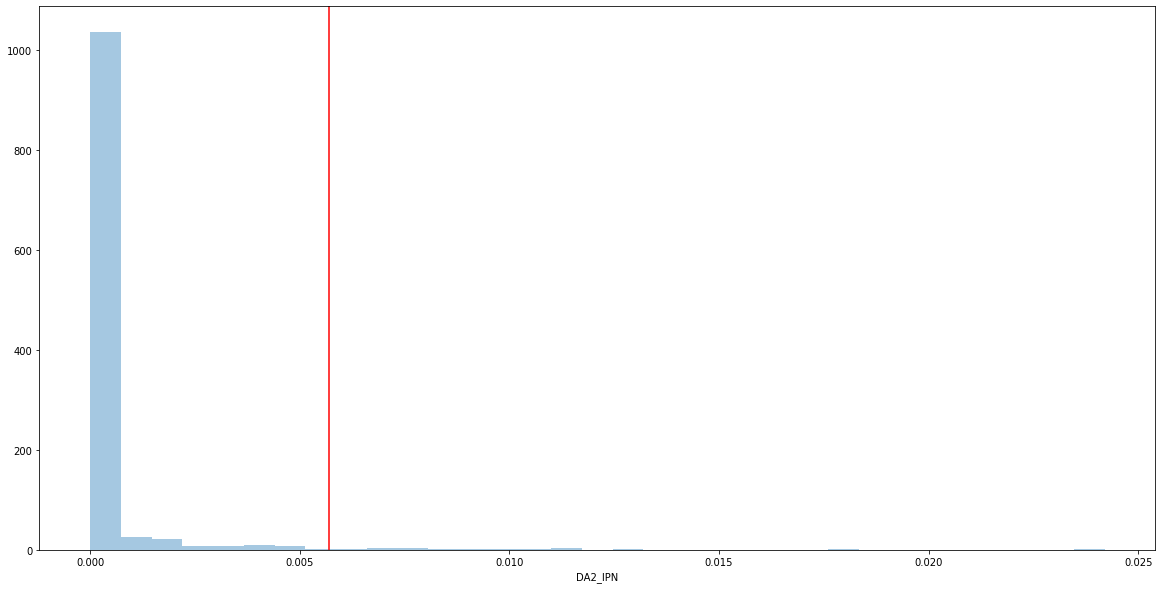

In [466]:
plt.figure(figsize=(20,10))
sns.distplot(DA2_out_prop, kde=False)

plt.axvline(DA2_out_prop.loc[['LHAV1a1']].to_numpy(), color = 'red')

In [456]:
AV1a1 = uPN_lh_matrix_tot_norm[['LHAV1a1']]
AV1a1 = AV1a1.sort_values('LHAV1a1', ascending=False)
AV1a1.head(20)

type_post,LHAV1a1
type_pre,
VL1_vPN,0.058565
VM4_lvPN,0.044900
VA1v_adPN,0.043924
VL2p_adPN,0.031235
D_adPN,0.025378
DL4_adPN,0.023426
DL2d_adPN,0.021962
VL2a_adPN,0.019034
VM1_lPN,0.019034


In [308]:
#Filtering the dataset to make plotting easier to parse
uPN_lh_matrix_dist = uPN_lh_matrix_tot_norm[uPN_lh_matrix_tot_norm > 0]

In [499]:
def dist_percentile(dist, pct):
    dist_stack = dist.stack().reset_index()
    dist_p = dist_stack.quantile(pct)
    return dist_p

dist_percentile(uPN_lh_matrix_tot_norm, 0.95)

0    0.009615
Name: 0.95, dtype: float64

In [478]:
uPN_lh_matrix_tot_norm.loc[['DA2_lPN'], ['LHAV1a1']].to_numpy()

array([[0.01805759]])

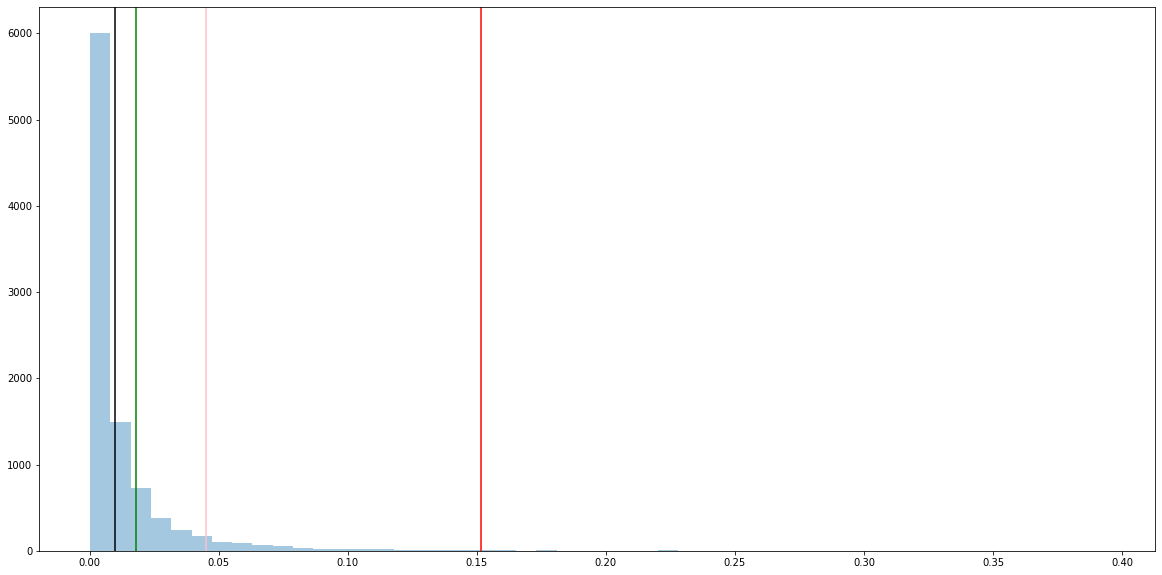

In [488]:
#Plotting distribution of normalised values, with lines for different example connections
plt.figure(figsize=(20,10))
sns.distplot(uPN_lh_matrix_dist, kde=False)
#sns.distplot(uPN_lh_matrix_tot_norm)

plt.axvline(uPN_lh_matrix_tot_norm.loc[['DA2_lPN'], ['LHAV1a1']].to_numpy(), color = 'green')
plt.axvline(uPN_lh_matrix_tot_norm.loc[['DA2_lPN'], ['LHAV4d3']].to_numpy(), color = 'red')
plt.axvline(uPN_lh_matrix_tot_norm.loc[['VM4_lvPN'], ['LHAV1a1']].to_numpy(), color = 'pink')
plt.axvline(dist_percentile(uPN_lh_matrix_tot_norm, 0.95).to_numpy(), color = 'black')

In [511]:
dist_percentile(uPN_lh_matrix_tot_norm, 0.95)

0    0.009615
Name: 0.95, dtype: float64

In [323]:
uPN_lh_matrix_dist.shape

(66, 1137)

<AxesSubplot:xlabel='type_post', ylabel='type_pre'>

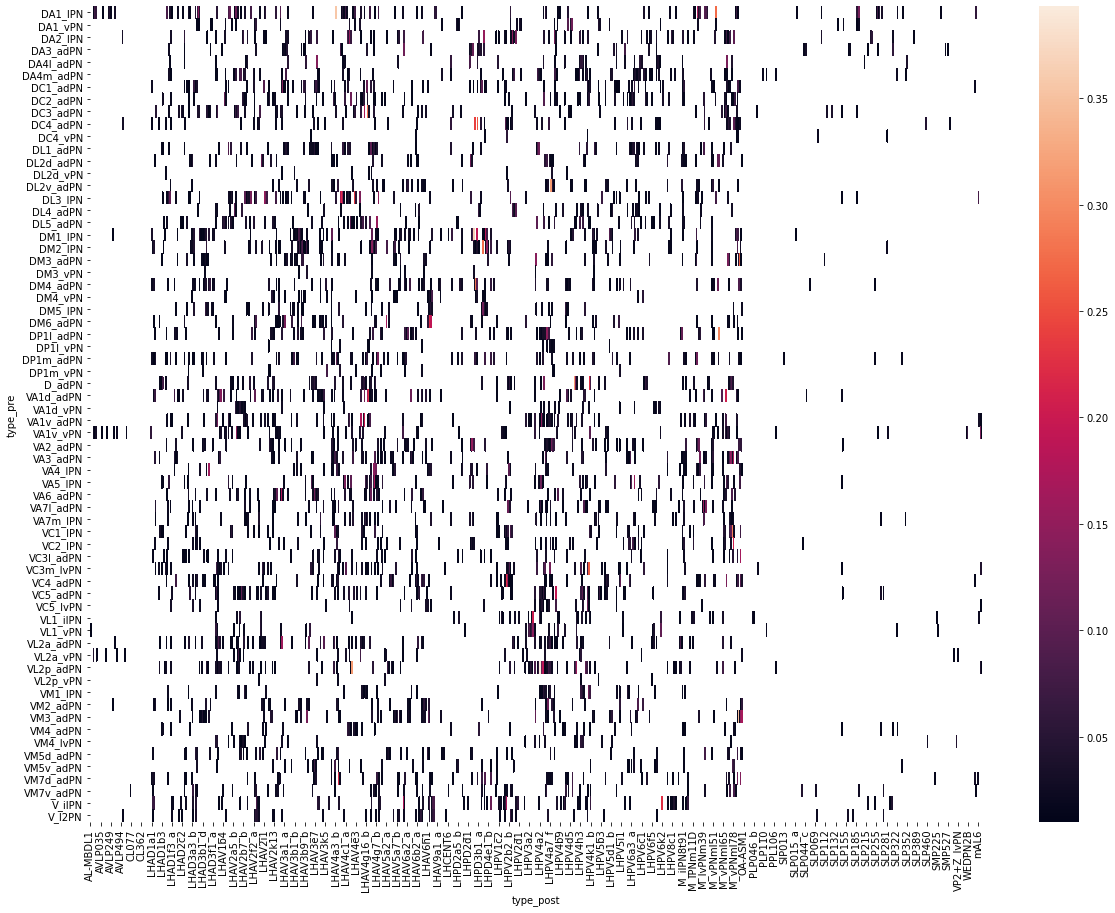

In [475]:
#Plotting a heatmap of connections...would be better if we could remove any zero values, but then we lose columns and rows, so unworkable at this stage.
#Might be easier with the final PN to DN table. The other thing to do is to finish this bit of code for now and get some plots, so that we can follow up in
#the literature anything that is a comparable input to DNp42 with a phenotype we can use and start thinking about testing that. 
uPN_lh_matrix_hm = uPN_lh_matrix_tot_norm[uPN_lh_matrix_tot_norm > 0.01]

plt.figure(figsize=(20,15))
sns.heatmap(uPN_lh_matrix_hm, yticklabels=True)

In [476]:
uPN_lh_matrix_hm.shape

(66, 1137)

In [ ]:
#Nothing notable about connectivity between DA2 and AV1a1...green for that, red for DA2 top target, which is...

### The comparison plots for this stage with the strict LHN filtering

In [670]:
#Normalise by total input to uPN targets
lh_ds_filt, lh_ds_filt_conn = fetch_adjacencies(None, uPN_lh_filt.bodyId_post)

In [671]:
from neuprint import merge_neuron_properties

lh_ds_f = merge_neuron_properties(lh_ds_filt, lh_ds_filt_conn, ['type', 'instance'])
lh_ds_f.sort_values('weight', ascending=False)

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
50578,517506265,480590566,LH(R),368,LHCENT4,LHCENT4_R,LHPV12a1,LHPV12a1(PVM10)_R
73145,612371421,421641859,SMP(R),237,MBON01,MBON01(y5B'2a)_R,LHPD4c1,LHPD4c1_R
50534,517506265,327499164,LH(R),222,LHCENT4,LHCENT4_R,LHCENT2,LHCENT2_R
30728,424789697,421641859,SIP(R),154,MBON02,MBON02(B2B'2a)_R,LHPD4c1,LHPD4c1_R
53124,542634818,728483069,LH(R),148,DM1_lPN,DM1_lPN_R,LHAV4a1_b,LHAV4a1_b_R
...,...,...,...,...,...,...,...,...
69866,605416852,5813013530,LH(R),1,LHPV4a5_b,LHPV4a5_b_R,LHAV2a3,LHAV2a3_R
69865,605416852,5813012448,LH(R),1,LHPV4a5_b,LHPV4a5_b_R,LHAV4b4,LHAV4b4_R
69864,605416852,5813010180,LH(R),1,LHPV4a5_b,LHPV4a5_b_R,LHPV5h1,LHPV5h1_R
69863,605416852,5813009749,LH(R),1,LHPV4a5_b,LHPV4a5_b_R,LHPD1a1,LHPD1a1_R


In [672]:
lh_ds_filt = connection_table_to_matrix(lh_ds_f, 'type', sort_by='type')
lh_ds_filt
lh_ds_filt.fillna(0)

type_post,LC43,LHAD1a1,LHAD1a2_b,LHAD1a2_c,LHAD1a3,LHAD1a4_a,LHAD1a4_b,LHAD1b2_a,LHAD1b2_b,LHAD1b2_c,...,M_vPNml86,M_vPNml89,PLP068,SLP018,SLP148,SLP264,aSP-f3,aSP-g2,mALB3,NaN
type_pre,,,,,,,,,,,,,,,,,,,,,
5-HTPLP01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5-HTPMPD01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5-HTPMPV01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5-HTPMPV03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL-AST1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vLN27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vLN28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vLN29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [673]:
#All ok at this stage
lh_ds_filt[['LHAV1a1']].sort_values('LHAV1a1', ascending = False).head(20)

type_post,LHAV1a1
type_pre,
VL1_vPN,120.0
VM4_lvPN,92.0
VA1v_adPN,90.0
LHPV2a1_c,69.0
LHAV4a2,67.0
VL2p_adPN,64.0
LHPV4g1,59.0
LHAV3f1,57.0
D_adPN,52.0


In [674]:
uPN_lh_filt_norm = uPN_lh_matrix_filt.div(lh_ds_filt.sum(axis = 0), axis = 1)
uPN_lh_filt_norm.fillna(0)

type_post,LC43,LHAD1a1,LHAD1a2_b,LHAD1a2_c,LHAD1a3,LHAD1a4_a,LHAD1a4_b,LHAD1b2_a,LHAD1b2_b,LHAD1b2_c,...,M_vPNml86,M_vPNml89,PLP068,SLP018,SLP148,SLP264,aSP-f3,aSP-g2,mALB3,NaN
type_pre,,,,,,,,,,,,,,,,,,,,,
DA1_lPN,0.0,0.000000,0.000000,0.000000,0.000000,0.009785,0.007168,0.000000,0.001008,0.000000,...,0.000000,0.0,0.0,0.045652,0.006085,0.000000,0.000000,0.058511,0.0,0.0
DA1_vPN,0.0,0.000000,0.001239,0.001252,0.000000,0.000000,0.000000,0.004408,0.002016,0.003700,...,0.000000,0.0,0.0,0.000000,0.007099,0.000000,0.000000,0.000000,0.0,0.0
DA2_lPN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001102,0.000000,0.002775,...,0.008287,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
DA3_adPN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000275,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
DA4l_adPN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001102,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.003043,0.003322,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM5v_adPN,0.0,0.000000,0.002478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000463,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
VM7d_adPN,0.0,0.018253,0.033457,0.030038,0.001684,0.005871,0.000000,0.000275,0.000504,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.026087,0.015957,0.0,0.0
VM7v_adPN,0.0,0.003911,0.013631,0.002503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.010638,0.0,0.0


In [675]:
#And all fine here
uPN_lh_filt_norm[['LHAV1a1']].sort_values('LHAV1a1', ascending = False).head(20)

type_post,LHAV1a1
type_pre,
VL1_vPN,0.058565
VM4_lvPN,0.044900
VA1v_adPN,0.043924
VL2p_adPN,0.031235
D_adPN,0.025378
DL4_adPN,0.023426
DL2d_adPN,0.021962
VL2a_adPN,0.019034
VM1_lPN,0.019034


In [505]:
#Filtering the dataset to make plotting easier to parse
filt_dist = uPN_lh_filt_norm[uPN_lh_filt_norm > 0]

In [345]:
#Still all fine here
filt_dist[['LHAV1a1']].sort_values('LHAV1a1', ascending = False).head(20)

type_post,LHAV1a1
type_pre,
VL1_vPN,0.058565
VM4_lvPN,0.044900
VA1v_adPN,0.043924
VL2p_adPN,0.031235
D_adPN,0.025378
DL4_adPN,0.023426
DL2d_adPN,0.021962
VL2a_adPN,0.019034
VM1_lPN,0.019034


In [324]:
filt_dist.shape

(66, 537)

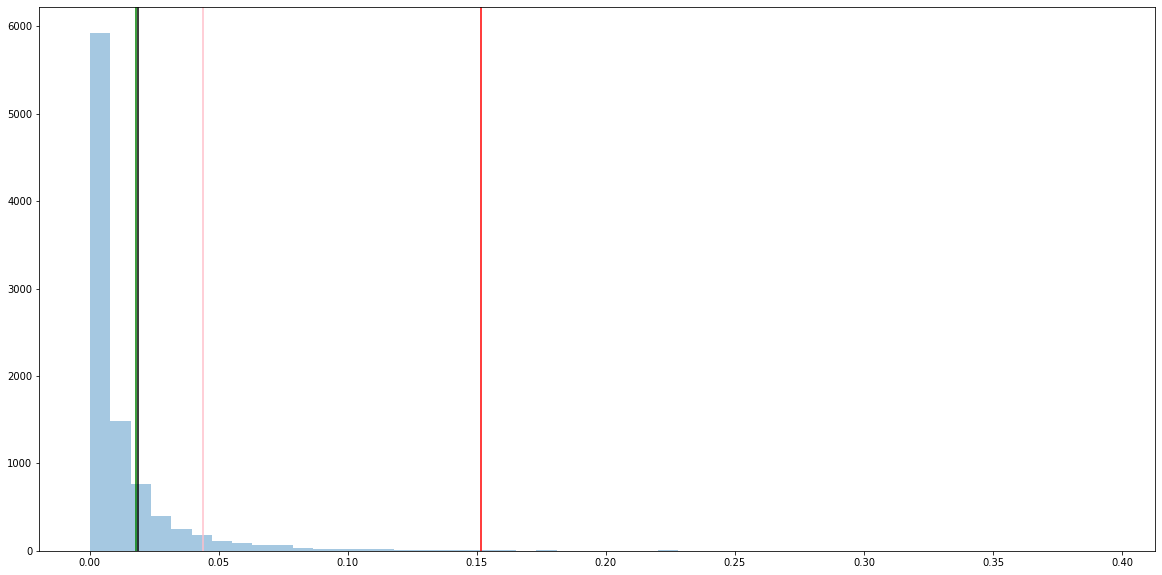

In [507]:
#Plotting distribution of normalised values, with lines for different example connections
plt.figure(figsize=(20,10))
sns.distplot(filt_dist, kde=False)

plt.axvline(uPN_lh_filt_norm.loc[['DA2_lPN'], ['LHAV1a1']].to_numpy(), color = 'green')
plt.axvline(uPN_lh_filt_norm.loc[['DA2_lPN'], ['LHAV4d3']].to_numpy(), color = 'red')
plt.axvline(uPN_lh_filt_norm.loc[['VA1v_adPN'], ['LHAV1a1']].to_numpy(), color = 'pink')
plt.axvline(dist_percentile(uPN_lh_filt_norm, 0.95).to_numpy(), color = 'black')

In [512]:
dist_percentile(uPN_lh_filt_norm, 0.95).to_numpy()

array([0.01869495])

In [352]:
uPN_lh_filt_hm[['LHAV1a1']].sort_values('LHAV1a1', ascending = False).head(20)

type_post,LHAV1a1
type_pre,
VL1_vPN,0.058565
VM4_lvPN,0.044900
VA1v_adPN,0.043924
VL2p_adPN,0.031235
D_adPN,0.025378
DL4_adPN,0.023426
DL2d_adPN,0.021962
VL2a_adPN,0.019034
VM1_lPN,0.019034


<AxesSubplot:xlabel='type_post', ylabel='type_pre'>

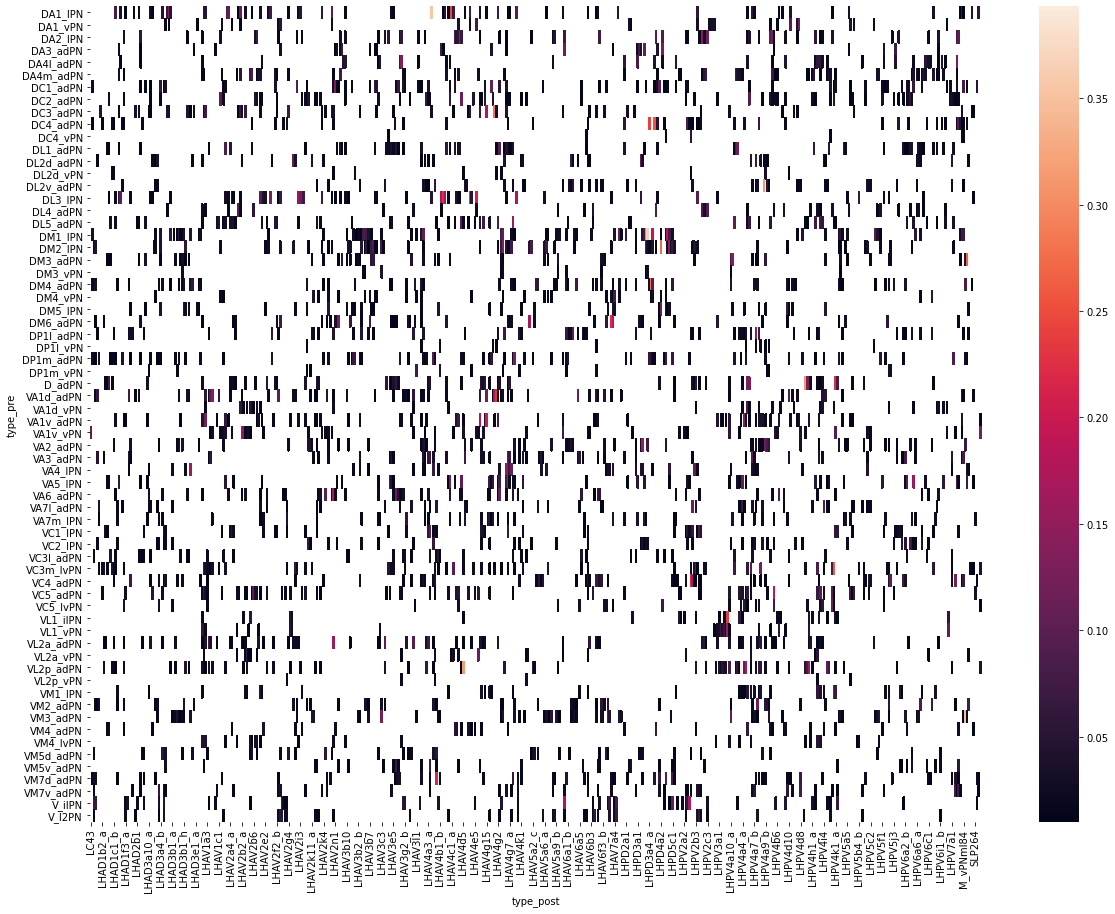

In [350]:
#Plotting a heatmap of connections...would be better if we could remove any zero values, but then we lose columns and rows, so unworkable at this stage.
#Might be easier with the final PN to DN table. The other thing to do is to finish this bit of code for now and get some plots, so that we can follow up in
#the literature anything that is a comparable input to DNp42 with a phenotype we can use and start thinking about testing that. 
uPN_lh_filt_hm = uPN_lh_filt_norm[uPN_lh_filt_norm > 0.01]

plt.figure(figsize=(20,15))
sns.heatmap(uPN_lh_filt_hm, yticklabels=True)

## Load DNs for LHN to DN matrix

In [696]:
dn_ids = pd.read_csv("DNs.csv")
dn_ids

,Unnamed: 0,value
0,1,1072059176
1,2,482356368
2,3,5813056909
3,4,5813021112
4,5,1140245595
...,...,...
340,341,5813020347
341,342,5813026404
342,343,5813048234
343,344,5813077405


In [697]:
from neuprint import fetch_neurons
dn_df, dn_roi_counts_df = fetch_neurons(dn_ids.value)

In [356]:
#dn_df[['bodyId', 'instance', 'type', 'pre', 'post', 'status', 'cropped', 'size']]

In [357]:
#Get list of missing BIDs

#bids_to_add = list(set(lhns_2) - set(lhns_1)) 

In [421]:
uPN_lh_matrix_tot_norm = uPN_lh_matrix_tot_norm.fillna(0)
uPN_lh_matrix_tot_norm

type_post,AL-MBDL1,ALIN3,AOTU043,APL,AVLP003,AVLP010,AVLP012,AVLP013,AVLP014,AVLP015,...,aSP-f3,aSP-g2,aSP-g3A,mAL4,mAL6,mALB1,mALB2,mALB3,mALB4,NaN
type_pre,,,,,,,,,,,,,,,,,,,,,
DA1_lPN,0.000000,0.0,0.0,0.000980,0.0,0.016064,0.075269,0.057971,0.0,0.000000,...,0.000652,0.059295,0.000000,0.000000,0.0,0.007173,0.0,0.0,0.0,0.0
DA1_vPN,0.000000,0.0,0.0,0.000008,0.0,0.000000,0.000000,0.000000,0.0,0.002245,...,0.000000,0.003205,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
DA2_lPN,0.000000,0.0,0.0,0.000209,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.001304,0.000000,0.000000,0.000000,0.0,0.000422,0.0,0.0,0.0,0.0
DA3_adPN,0.000000,0.0,0.0,0.000134,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
DA4l_adPN,0.000000,0.0,0.0,0.000059,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM5v_adPN,0.000000,0.0,0.0,0.000117,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
VM7d_adPN,0.000000,0.0,0.0,0.000142,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.028683,0.006410,0.000000,0.020588,0.0,0.000000,0.0,0.0,0.0,0.0
VM7v_adPN,0.001646,0.0,0.0,0.000084,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.001304,0.014423,0.002545,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


## Using DA2_ds to get DN connectivity

In [623]:
len(uPN_ds.tolist())

2864

In [625]:
uPN_ds

array([ 263674097,  264014957,  295443724, ...,  699161931,  885404254,
       5813086037])

In [698]:
upstream_ids = uPN_ds.tolist()
downstream_ids = dn_df.bodyId.tolist()

In [699]:
upstream_filter = neu.NeuronCriteria(bodyId=upstream_ids)
downstream_filter = neu.NeuronCriteria(bodyId=downstream_ids)

In [702]:
# Fetch edges
meta, edges = neu.fetch_adjacencies(upstream_filter, downstream_filter)

In [703]:
# Add types to edges
types = meta.set_index('bodyId').type
edges['type_pre'] = edges.bodyId_pre.map(types)
edges['type_post'] = edges.bodyId_post.map(types)

In [704]:
# Sum edges across types and ROIs
edges_grp = edges.groupby(['type_pre', 'type_post'], as_index=False).weight.sum()

In [705]:
# Pivot to turn into a matrix (sources = rows, targets = columns)
df = edges_grp.pivot(index='type_pre', columns='type_post', values='weight')

In [706]:
df = df.fillna(0)
df

type_post,AVLP281,AVLP564,CL052,CL124,CL137,CL138,CL139,CL202,CL207,CL208,...,VES081,VES082,VES083,WED105,WED123,WED149,WED180,oviDNa,oviDNb,vpoDN
type_pre,,,,,,,,,,,,,,,,,,,,,
ALIN3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AOTU043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AVLP003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AVLP010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mAL6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mALB1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mALB2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [707]:
'APL' in df.index.unique()

True

### Doing the same with the filtered LHNs (uPN_ds)

In [677]:
uPN_lh_filt_norm

type_post,LC43,LHAD1a1,LHAD1a2_b,LHAD1a2_c,LHAD1a3,LHAD1a4_a,LHAD1a4_b,LHAD1b2_a,LHAD1b2_b,LHAD1b2_c,...,M_vPNml86,M_vPNml89,PLP068,SLP018,SLP148,SLP264,aSP-f3,aSP-g2,mALB3,NaN
type_pre,,,,,,,,,,,,,,,,,,,,,
DA1_lPN,0.0,0.000000,0.000000,0.000000,0.000000,0.009785,0.007168,0.000000,0.001008,0.000000,...,0.000000,0.0,0.0,0.045652,0.006085,0.000000,0.000000,0.058511,0.0,NaN
DA1_vPN,0.0,0.000000,0.001239,0.001252,0.000000,0.000000,0.000000,0.004408,0.002016,0.003700,...,0.000000,0.0,0.0,0.000000,0.007099,0.000000,0.000000,0.000000,0.0,NaN
DA2_lPN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001102,0.000000,0.002775,...,0.008287,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN
DA3_adPN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000275,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN
DA4l_adPN,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001102,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.003043,0.003322,0.000000,0.000000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM5v_adPN,0.0,0.000000,0.002478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000463,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN
VM7d_adPN,0.0,0.018253,0.033457,0.030038,0.001684,0.005871,0.000000,0.000275,0.000504,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.026087,0.015957,0.0,NaN
VM7v_adPN,0.0,0.003911,0.013631,0.002503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.010638,0.0,NaN


In [683]:
len(uPN_filt_ds)

1179

In [685]:
len(uPN_lh_filt.bodyId_post.unique())

1179

In [686]:
uPN_filt_ds = uPN_lh_filt.bodyId_post.unique()

In [711]:
upstream_ids = uPN_filt_ds.tolist()
downstream_ids = dn_df.bodyId.tolist()

In [710]:
len(downstream_ids)

345

In [712]:
upstream_filter = neu.NeuronCriteria(bodyId=upstream_ids)
downstream_filter = neu.NeuronCriteria(bodyId=downstream_ids)

In [713]:
# Fetch edges
meta, edges = neu.fetch_adjacencies(upstream_filter, downstream_filter)

In [714]:
# Add types to edges
types = meta.set_index('bodyId').type
edges['type_pre'] = edges.bodyId_pre.map(types)
edges['type_post'] = edges.bodyId_post.map(types)

In [715]:
# Sum edges across types and ROIs
edges_grp = edges.groupby(['type_pre', 'type_post'], as_index=False).weight.sum()

In [716]:
# Pivot to turn into a matrix (sources = rows, targets = columns)
df = edges_grp.pivot(index='type_pre', columns='type_post', values='weight')

In [717]:
df = df.fillna(0)
df

type_post,AVLP281,AVLP564,CL137,CL202,CL207,CL305,CL306,CL307,CL310,CL311,...,SMP308,SMP462,SMP468,SMP478,SMP479,SMP545,WED123,WED180,oviDNa,oviDNb
type_pre,,,,,,,,,,,,,,,,,,,,,
LHAD1a1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
LHAD1a2_b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LHAD1a2_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LHAD1a3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LHAD1a4_a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLP148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SLP264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aSP-f3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Reindexing to make the matrix dimensions match

In [640]:
df.reindex(index = uPN_lh_matrix.columns).fillna(0)

type_post,5-HTPLP01,5-HTPMPD01,5-HTPMPV01,5-HTPMPV03,AL-AST1,ALIN3,AOTU009,AOTU012,AOTU015,AOTU016,...,mALD3,oviDNa,oviDNb,oviIN,pC1b,pC1c,pC1d,pC1e,v2LN30,vpoEN
type_post,,,,,,,,,,,,,,,,,,,,,
AL-MBDL1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALIN3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AOTU043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AVLP003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mALB1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mALB2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mALB3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [431]:
df.reindex(index=uPN_lh_matrix.columns).sum(axis=1).max()
df_reindexed = df.reindex(index=uPN_lh_matrix.columns).fillna(0)
df_reindexed

type_post,AVLP281,AVLP564,CL052,CL124,CL137,CL138,CL139,CL202,CL207,CL208,...,VES081,VES082,VES083,WED105,WED123,WED149,WED180,oviDNa,oviDNb,vpoDN
type_post,,,,,,,,,,,,,,,,,,,,,
AL-MBDL1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALIN3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AOTU043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AVLP003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mALB1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mALB2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mALB3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [718]:
#For the filtered set

df.reindex(index=uPN_lh_matrix_filt.columns).sum(axis=1).max()
df_reindexed = df.reindex(index=uPN_lh_matrix_filt.columns).fillna(0)
df_reindexed

type_post,AVLP281,AVLP564,CL137,CL202,CL207,CL305,CL306,CL307,CL310,CL311,...,SMP308,SMP462,SMP468,SMP478,SMP479,SMP545,WED123,WED180,oviDNa,oviDNb
type_post,,,,,,,,,,,,,,,,,,,,,
LC43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LHAD1a1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
LHAD1a2_b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LHAD1a2_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LHAD1a3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLP264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aSP-f3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
aSP-g2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalise by total input from the list of PN targets (not useful)

In [571]:
#Normalise by selected PN target inputs
#df_reindexed_lh_norm = df_reindexed.div(df_reindexed.sum(axis = 0), axis = 1)
#df_reindexed_lh_norm.fillna(0)

type_post,AVLP281,AVLP564,CL052,CL124,CL137,CL138,CL139,CL202,CL207,CL208,...,VES081,VES082,VES083,WED105,WED123,WED149,WED180,oviDNa,oviDNb,vpoDN
type_post,,,,,,,,,,,,,,,,,,,,,
AL-MBDL1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ALIN3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AOTU043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AVLP003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mALB1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mALB2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mALB3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [572]:
#np.count_nonzero(df_reindexed_lh_norm)

3447

## Normalising by total DN input

In [720]:
df_reindexed.columns.tolist()

['AVLP281',
 'AVLP564',
 'CL137',
 'CL202',
 'CL207',
 'CL305',
 'CL306',
 'CL307',
 'CL310',
 'CL311',
 'CL320',
 'CL324',
 'CL330',
 'CL332',
 'CL337',
 'CL338',
 'CL341',
 'DNES2',
 'DNa02',
 'DNa08',
 'DNb05',
 'DNg30',
 'DNp04',
 'DNp06',
 'DNp07',
 'DNp09',
 'DNp10',
 'DNp13',
 'DNp18',
 'DNp23',
 'DNp24',
 'DNp25',
 'DNp26',
 'DNp27',
 'DNp32',
 'DNp34',
 'DNp42',
 'DNp44',
 'DSKMP1A',
 'DSKMP1B',
 'LHPV11a1',
 'NPFP1',
 'PLP229',
 'PS271',
 'PVLP116',
 'PVLP119',
 'PVLP136',
 'PVLP137',
 'PVLP145',
 'PVLP146',
 'SAD041',
 'SIFa',
 'SLP410',
 'SMP258',
 'SMP259',
 'SMP263',
 'SMP265',
 'SMP307',
 'SMP308',
 'SMP462',
 'SMP468',
 'SMP478',
 'SMP479',
 'SMP545',
 'WED123',
 'WED180',
 'oviDNa',
 'oviDNb']

In [721]:
#Get total DN input...should be all DNs, then get an array of total input for each, and multiply each element of a column in the other matrix by this number for total numbers
dn_df, dn_conn_df = fetch_adjacencies(None, df_reindexed.columns.tolist())


In [722]:
from neuprint import merge_neuron_properties

dn_conn_df = merge_neuron_properties(dn_df, dn_conn_df, ['type', 'instance'])
dn_conn_df
dn_conn_df.sort_values('weight', ascending=False)

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
12841,695124651,1072063538,PLP(R),496,aMe3,aMe3,DNp27,DNp27_R
47190,1723325539,1405231475,PVLP(R),236,None,None,DNp04,DNp04_R
35699,1375224269,1100404634,PLP(R),228,PLP034,PLP034_R,DNp26,DNp26_R
60370,5813027276,5813057178,PVLP(R),200,AVLP080,AVLP080_R,PVLP136,PVLP136_R
26047,1066511487,1072063538,PLP(R),159,aMe8,aMe8_R,DNp27,DNp27_R
...,...,...,...,...,...,...,...,...
28205,1132781911,981000564,ICL(R),1,None,None,DNp42,DNp42_R
28206,1132781911,1200619473,SPS(R),1,None,None,CL337,CL337_R
28207,1132781911,1200619473,ICL(R),1,None,None,CL337,CL337_R
28214,1132811822,1011184205,ICL(L),1,None,None,DSKMP1B,DSKMP1B(PVM02)_L


In [723]:
# Sum edges across types and ROIs
dn_edges_grp = dn_conn_df.groupby(['type_post'], as_index=False).weight.sum()
dn_edges_grp

,type_post,weight
0,AVLP281,1251
1,AVLP564,417
2,CL137,2032
3,CL202,3112
4,CL207,1081
...,...,...
63,SMP545,4519
64,WED123,1504
65,WED180,3912
66,oviDNa,1055


In [40]:
#Threshold those with particular input numbers? 
#dn_edges_grp[dn_edges_grp['weight'] > 100]

In [724]:
#Normalise by total weight
df_reindexed_tot_norm = df_reindexed.div(dn_edges_grp['weight'].tolist(), axis = 1)
df_reindexed_tot_norm.fillna(0)

type_post,AVLP281,AVLP564,CL137,CL202,CL207,CL305,CL306,CL307,CL310,CL311,...,SMP308,SMP462,SMP468,SMP478,SMP479,SMP545,WED123,WED180,oviDNa,oviDNb
type_post,,,,,,,,,,,,,,,,,,,,,
LC43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
LHAD1a1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.004796,0.0,0.0,0.0,0.000000,0.0
LHAD1a2_b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
LHAD1a2_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
LHAD1a3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLP264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011416,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
aSP-f3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.002398,0.0,0.0,0.0,0.000948,0.0
aSP-g2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [725]:
np.count_nonzero(df_reindexed_tot_norm)

729

In [726]:
dn_edges_grp.loc[dn_edges_grp['type_post'] == 'VES083']

,type_post,weight


In [727]:
df_reindexed.loc[['ALIN3'], ['VES083']]

KeyError: "None of [Index(['ALIN3'], dtype='object', name='type_post')] are in the [index]"

In [381]:
#You can use loc[row_indexer, column_indexer] to filter rows and columns that sum to different values
#df_tidy = df.loc[(df.sum(axis=1) !=0), (df.sum(axis=0) !=0)]

type_post,AVLP281,AVLP564,CL052,CL124,CL137,CL138,CL139,CL202,CL207,CL208,...,VES081,VES082,VES083,WED105,WED123,WED149,WED180,oviDNa,oviDNb,vpoDN
type_pre,,,,,,,,,,,,,,,,,,,,,
ALIN3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AOTU043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AVLP003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AVLP010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aSP-f1A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
aSP-f3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0
aSP-g2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0


In [728]:
AV1_DNp42 = df_reindexed_tot_norm[["DNp42"]]
AV1_DNp42 = AV1_DNp42.sort_values('DNp42', ascending=False)
AV1_DNp42.head(10)

type_post,DNp42
type_post,
LHAV1a1,0.011159
LHAV1a3,0.010071
LHAV1a4,0.001905
LHAV1b2,0.001361
LHPV3b1_b,0.001089
LHAV1b1,0.000817
LHAV2b4,0.000544
LHPV6c1,0.000544
LHPV3a3_c,0.000544


In [530]:
def dist_percentile(dist, pct):
    dist_stack = dist.stack()
    dist_p = dist_stack.quantile(pct)
    return dist_p

dist_percentile(df_reindexed_tot_norm, 0.95)

0.0

In [527]:
dist_stack = df_reindexed_tot_norm.stack()
dist_stack.quantile(0.99)

0.0005382131324004305

In [543]:
df_reindexed_tot_norm[['DNp44']].sort_values('DNp44', ascending = False)

type_post,DNp44
type_post,
VP4_vPN,0.113240
VP5+Z_adPN,0.090592
VP4+_vPN,0.087108
LHPV4g1,0.033101
CL002,0.029617
...,...
LHAV5a9_b,0.000000
LHAV5b1,0.000000
LHAV5b2,0.000000


In [544]:
df_reindexed_tot_norm[['DNg30']].sort_values('DNg30', ascending = False)

type_post,DNg30
type_post,
AVLP594,0.0920
VP5+Z_adPN,0.0264
VP4+_vPN,0.0224
AVLP030,0.0192
VP4_vPN,0.0080
...,...
LHAV5a7_b,0.0000
LHAV5a7_c,0.0000
LHAV5a8,0.0000


### An important note here...there is a lot of converging VPN and DA2 signal onto DNg30, via AVLP594, which is ADLI. Did we have the line for ADLI? And can we get it back? Is humidity and geosmin converging here? Are they related signals? Could they have some circadian relevance? We'll know this after we've maybe had a look at the circadian cells. Important to keep neuropeptidergic signalling in mind, as lots of circadian stuff happens this way. 

In [545]:
df_reindexed_tot_norm.max().sort_values(ascending = False).head(20)

type_post
DNp44       0.113240
DNg30       0.092000
DNp24       0.088757
SMP260      0.065957
DNp25       0.059194
VES055      0.044608
SMP308      0.039954
DNp32       0.036949
DNp42       0.035928
SAD041      0.034853
VES069      0.032382
VES042      0.031029
SMP259      0.030238
LHPV11a1    0.029826
VES081      0.029553
SMP479      0.028777
DNp06       0.028520
CL330       0.028340
DSKMP1B     0.028282
WED149      0.026398
dtype: float64

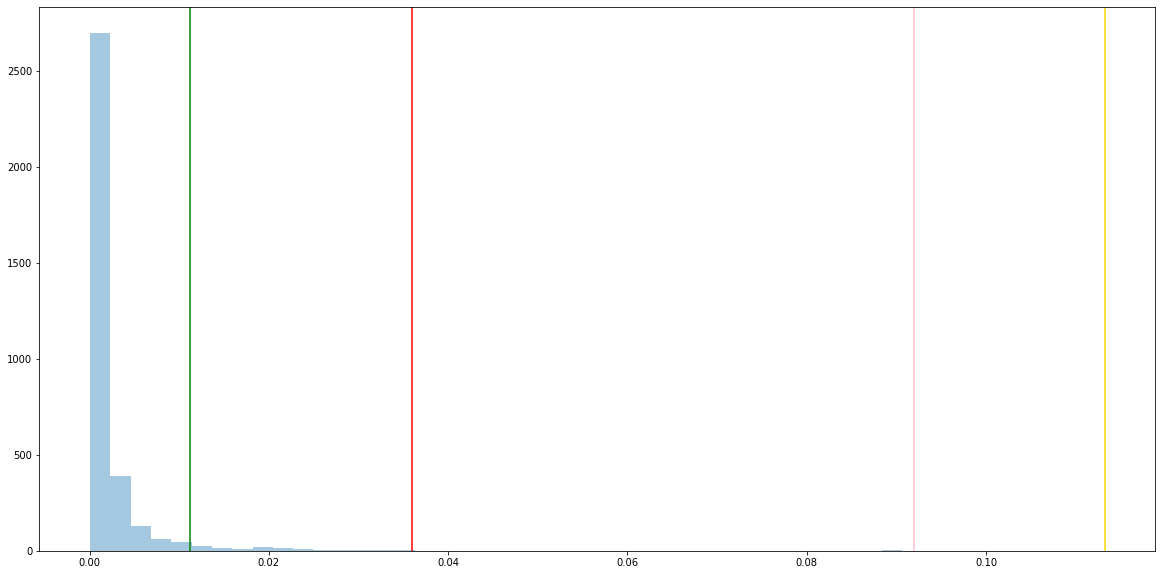

In [548]:
df_reindexed_dist = df_reindexed_tot_norm[df_reindexed_tot_norm > 0]
plt.figure(figsize=(20,10))

sns.distplot(df_reindexed_dist, kde = False)

plt.axvline(df_reindexed_tot_norm.loc[['LHAV1a1'], ['DNp42']].to_numpy(), color = 'green')
plt.axvline(df_reindexed_tot_norm.loc[['CL078'], ['DNp42']].to_numpy(), color = 'red')
plt.axvline(df_reindexed_tot_norm.loc[['AVLP594'], ['DNg30']].to_numpy(), color = 'pink')
plt.axvline(df_reindexed_tot_norm.loc[['VP4_vPN'], ['DNp44']].to_numpy(), color = 'gold')
#plt.axvline(dist_percentile(df_reindexed_tot_norm, 0.99), color = 'black')

In [ ]:
plt.axvline(uPN_lh_filt_norm.loc[['DA2_lPN'], ['LHAV1a1']].to_numpy(), color = 'green')
plt.axvline(uPN_lh_filt_norm.loc[['DA2_lPN'], ['LHAV4d3']].to_numpy(), color = 'red')
plt.axvline(uPN_lh_filt_norm.loc[['VA1v_adPN'], ['LHAV1a1']].to_numpy(), color = 'pink')
plt.axvline(dist_percentile(uPN_lh_filt_norm, 0.95).to_numpy(), color = 'black')

<AxesSubplot:xlabel='type_post', ylabel='type_post'>

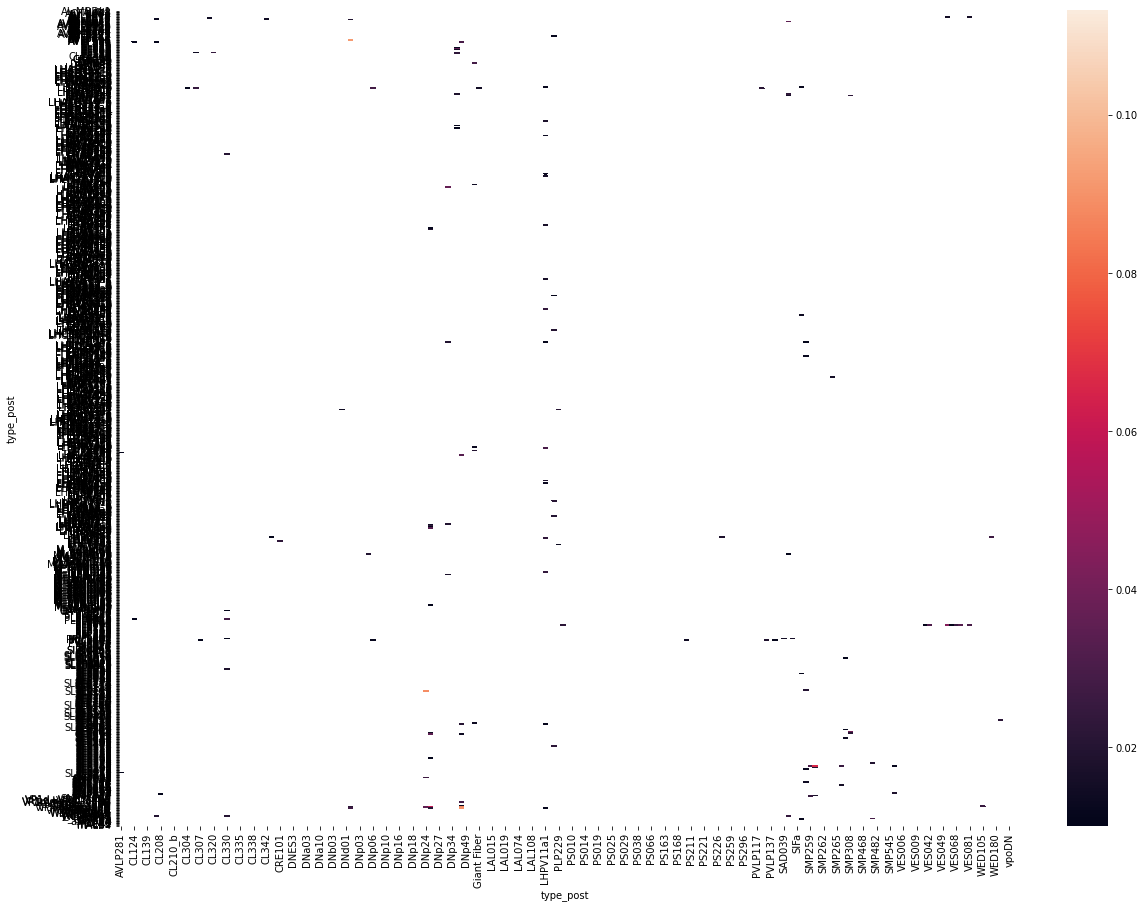

In [513]:
#Plotting a heatmap of connections...would be better if we could remove any zero values, but then we lose columns and rows, so unworkable at this stage.
#Might be easier with the final PN to DN table. The other thing to do is to finish this bit of code for now and get some plots, so that we can follow up in
#the literature anything that is a comparable input to DNp42 with a phenotype we can use and start thinking about testing that. 
reindexed_filt_hm = df_reindexed_tot_norm[df_reindexed_tot_norm > 0.01]

plt.figure(figsize=(20,15))
sns.heatmap(reindexed_filt_hm, yticklabels=True)

In [ ]:
#Maybe we should filter this matrix by the top 30 DA2 downstreams to get a heatmap of that...that could be interesting, just wouldn't include AV1a1, but would give us other DNs to be aware of for the geosmin phenotype





## Matrix Multiplication

In [730]:
uPN_lh_filt_norm.fillna(0).shape

(66, 537)

In [731]:
df_reindexed_tot_norm.fillna(0).shape

(537, 68)

In [729]:
mm = uPN_lh_filt_norm.fillna(0) @ df_reindexed_tot_norm.fillna(0)

mm

type_post,AVLP281,AVLP564,CL137,CL202,CL207,CL305,CL306,CL307,CL310,CL311,...,SMP308,SMP462,SMP468,SMP478,SMP479,SMP545,WED123,WED180,oviDNa,oviDNb
type_pre,,,,,,,,,,,,,,,,,,,,,
DA1_lPN,0.000006,0.000000,0.000000,1.333348e-06,4.694195e-05,0.000072,0.0,0.0,0.000002,0.000265,...,0.000788,1.089983e-06,0.000002,0.0,0.000000,0.000001,0.0,9.281907e-08,0.000043,8.371497e-05
DA1_vPN,0.000032,0.000258,0.000000,4.307463e-07,3.129463e-06,0.000000,0.0,0.0,0.000000,0.000009,...,0.000068,4.087437e-07,0.000002,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000,8.460016e-06
DA2_lPN,0.000009,0.000000,0.000033,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000004,...,0.000058,0.000000e+00,0.000068,0.0,0.000000,0.000000,0.0,1.856381e-07,0.000000,4.361540e-07
DA3_adPN,0.000003,0.000000,0.000000,1.292239e-06,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,...,0.000032,5.041172e-06,0.000026,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00
DA4l_adPN,0.000005,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,...,0.000218,8.174874e-07,0.000043,0.0,0.000000,0.000001,0.0,0.000000e+00,0.000000,6.450364e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VM5v_adPN,0.000025,0.000007,0.000000,0.000000e+00,9.388390e-06,0.000000,0.0,0.0,0.000000,0.000015,...,0.000066,0.000000e+00,0.000000,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00
VM7d_adPN,0.000096,0.000001,0.000004,2.000021e-06,6.258927e-07,0.000000,0.0,0.0,0.000000,0.000000,...,0.000097,0.000000e+00,0.000000,0.0,0.000150,0.000000,0.0,0.000000e+00,0.000025,1.919751e-06
VM7v_adPN,0.000033,0.000000,0.000000,6.666738e-07,0.000000e+00,0.000000,0.0,0.0,0.000000,0.000000,...,0.000005,0.000000e+00,0.000000,0.0,0.000061,0.000000,0.0,0.000000e+00,0.000000,0.000000e+00


## Plotting distribution of values to get some idea of what's typical

## Need to find a way of plotting non-zero values in the distribution? Or is that misleading? Good to have both...the actual distribution of PNs to DNs, but also the distribution of connections that exist, and the place of our circuit within that

In [ ]:
# First let's look at some of our things and get values to plot on the general distribution...should we be removing the top values? 

In [733]:
DNp42 = mm[["DNp42"]]
DNp42.sort_values(by='DNp42', ascending=False).head(20)

type_post,DNp42
type_pre,
VL1_vPN,0.000921
VA1v_adPN,0.000533
VL2p_adPN,0.000525
VM4_lvPN,0.000514
VL1_ilPN,0.000488
VL2a_adPN,0.000397
VC5_adPN,0.000347
VC3m_lvPN,0.000319
D_adPN,0.000300


In [734]:
DA2_mm = mm.loc['DA2_lPN']
DA2_mm.sort_values(ascending=False).head(20)

type_post
DNp25       0.001613
SLP410      0.001113
LHPV11a1    0.000939
DNp32       0.000562
NPFP1       0.000481
DNg30       0.000325
DSKMP1B     0.000255
DNp42       0.000213
CL332       0.000174
CL330       0.000154
DNp44       0.000142
SIFa        0.000097
SMP468      0.000068
DNp06       0.000066
SMP308      0.000058
CL320       0.000047
SMP307      0.000047
CL137       0.000033
DSKMP1A     0.000030
DNES2       0.000018
Name: DA2_lPN, dtype: float64

In [738]:
#Removing all 0 values
mm_dist = mm[mm > 0]

In [739]:
mm_stack_dist = mm_dist.stack().reset_index()
mm_stack_dist.max()

type_pre         V_l2PN
type_post        oviDNb
0            0.00539929
dtype: object

In [740]:
def dist_percentile(dist, pct):
    dist_stack = dist.stack()
    dist_p = dist_stack.quantile(pct)
    return dist_p

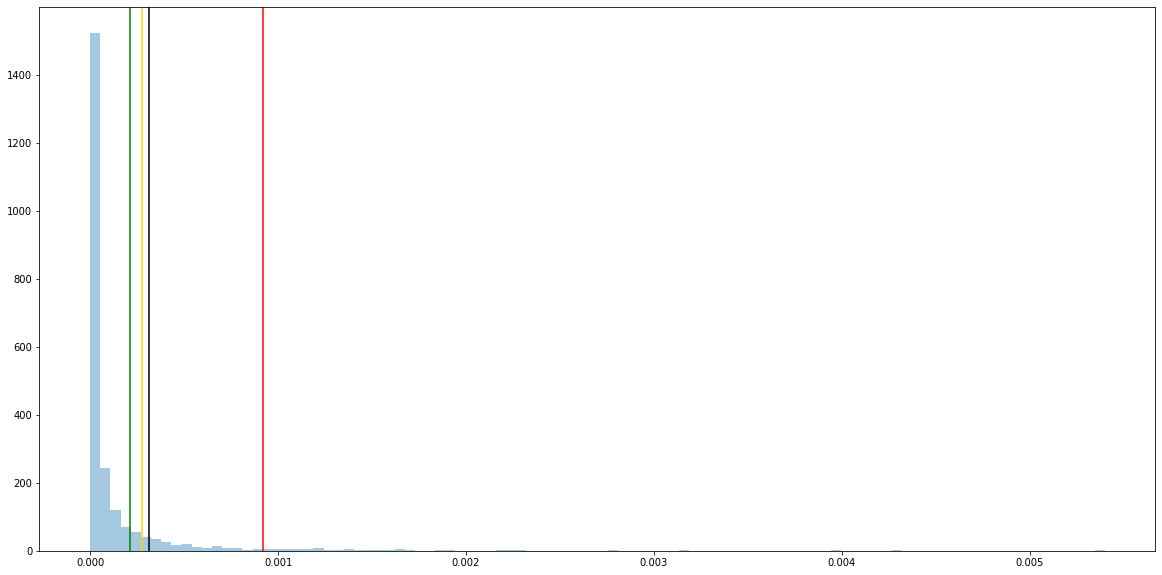

In [741]:
#First, the distribution and lines for the distribution without 0 values
plt.figure(figsize=(20,10))
sns.distplot(mm_dist, bins = 100, kde = False)

plt.axvline(dist_percentile(mm, 0.95), color = 'black')
plt.axvline(mm.loc[['DA2_lPN'], ['DNp42']].to_numpy(), color = 'green')
plt.axvline(mm.loc[['VL1_vPN'], ['DNp42']].to_numpy(), color = 'red')
plt.axvline(mm.loc[['DL4_adPN'], ['DNp42']].to_numpy(), color = 'gold')

0    0.000041
Name: 0.9, dtype: float64

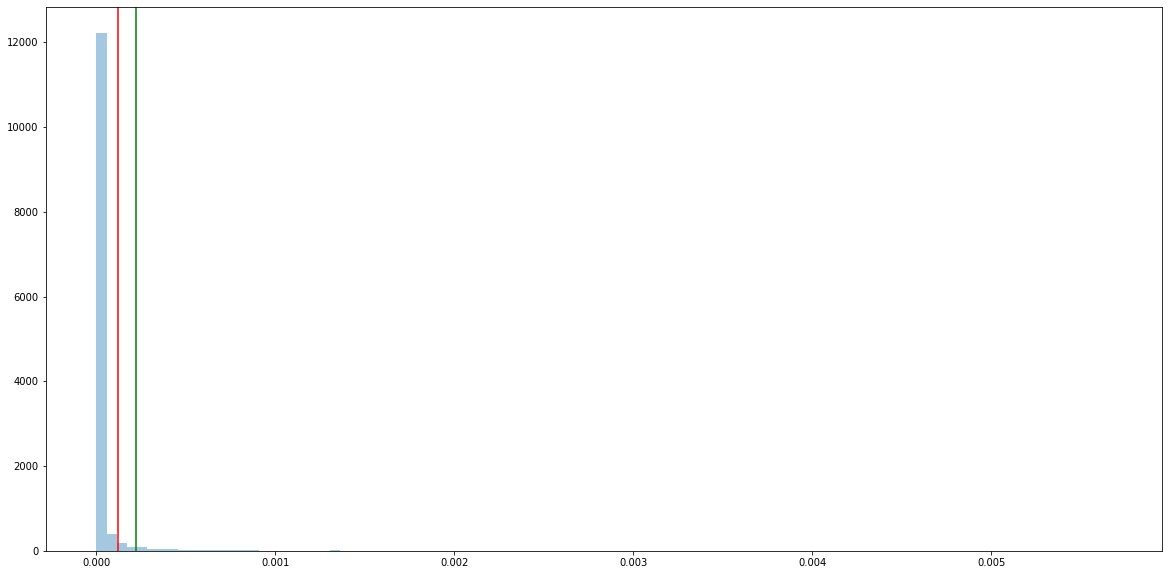

In [445]:
#Now for the whole thing
plt.figure(figsize=(20,10))
sns.distplot(mm, bins=100, kde = False)

plt.axvline(dist_percentile(mm, 0.95).to_numpy(), color = 'red')
plt.axvline(mm.loc[['DA2_lPN'], ['DNp42']].to_numpy(), color = 'green')
plt.savefig("DA2_DNp42_EC_whole_dist.png")

In [132]:
#Let's look at the big EC outputs and see if they need removing

In [452]:
mm.values.max()

0.005667538810432069

In [553]:
cols_max = mm.max()
cols_max.sort_values(ascending=False).head(50)

type_post
DSKMP1B     0.005668
DNp44       0.005512
LHPV11a1    0.004958
DNg30       0.003274
DNp32       0.002887
NPFP1       0.002541
DSKMP1A     0.002435
SLP410      0.001939
DNp25       0.001932
SAD041      0.001276
DNp24       0.001229
CL330       0.001182
DNp42       0.001175
SMP308      0.000787
DNp05       0.000755
SMP258      0.000670
DNp09       0.000652
CL332       0.000603
DNp06       0.000534
CRE101      0.000509
PLP229      0.000465
DNES2       0.000430
SMP259      0.000411
DNb05       0.000407
AVLP281     0.000401
SMP479      0.000400
PVLP145     0.000379
SMP307      0.000375
CL207       0.000371
CL310       0.000356
DNp02       0.000344
SMP260      0.000321
CL311       0.000316
PVLP119     0.000302
oviDNb      0.000296
CL307       0.000295
CL320       0.000291
SIFa        0.000276
DNp34       0.000274
CL342       0.000273
AVLP564     0.000273
vpoDN       0.000266
SMP263      0.000244
SMP468      0.000244
VES042      0.000243
PVLP146     0.000239
CRE015      0.000227
SMP

In [131]:
#Extracting particular PNs that give these values

In [586]:
DA1_mm = mm.loc['DA2_lPN']
DA1_mm.sort_values(ascending=False).head(20)

type_post
DNg30       0.003274
SLP410      0.001939
DNp25       0.001932
DNp44       0.001709
LHPV11a1    0.001679
CL330       0.001182
DNp32       0.000780
NPFP1       0.000694
SMP479      0.000391
DSKMP1B     0.000299
SMP468      0.000244
DNp42       0.000222
CL332       0.000209
DNp24       0.000186
oviDNb      0.000177
PS166       0.000164
SIFa        0.000134
SMP464      0.000118
oviDNa      0.000094
DNES2       0.000070
Name: DA2_lPN, dtype: float64

In [769]:
DNp24_in = df_reindexed_tot_norm[['DNp24']]
DNp24_in.sort_values('DNp24', ascending=False).head(20)

type_post,DNp24
type_post,
SLP131,0.088757
VP4+_vPN,0.035503
SMP001,0.026627
PPM1201,0.008876
DSKMP3,0.008876
AVLP594,0.005917
DNp32,0.005917
SLP123,0.005917
OA-VPM3,0.005917


In [554]:
mm.idxmax()

type_post
AVLP281       V_ilPN
AVLP564      DA1_vPN
CL052      VM7v_adPN
CL124       DA3_adPN
CL137       VC5_adPN
             ...    
WED149      VL1_ilPN
WED180      VA1v_vPN
oviDNa       DA1_vPN
oviDNb       DA1_lPN
vpoDN        DA1_lPN
Length: 202, dtype: object

In [555]:
mm.idxmax(axis = 1)

type_pre
DA1_lPN       DSKMP1B
DA1_vPN       DSKMP1B
DA2_lPN         DNg30
DA3_adPN        DNp25
DA4l_adPN       DNp25
               ...   
VM5v_adPN      SLP410
VM7d_adPN    LHPV11a1
VM7v_adPN    LHPV11a1
V_ilPN          NPFP1
V_l2PN          NPFP1
Length: 66, dtype: object

In [556]:
mm_filt =  mm.loc[:, mm.sum(axis=0) > 0.05]

<AxesSubplot:xlabel='type_post', ylabel='type_pre'>

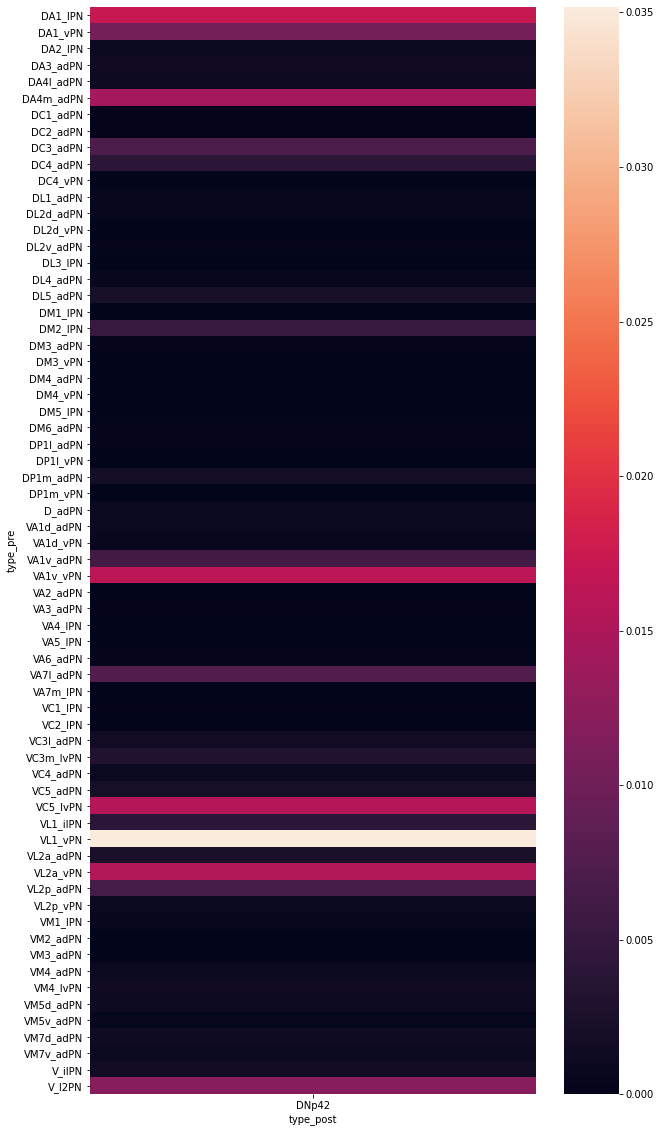

In [674]:
plt.figure(figsize=(10, 20))
sns.heatmap(DNp42, yticklabels=True)

## Finding a way to output the connecting cells of a particular DN/PN pair

In [ ]:
#So we could just get downstreams of a PN (with the same filtering?) then intersect that with upstreams of a particular DN. That list shouldn't be that long, and you can get proportions in the same way you did above. Simple. Good thing to do this afternoon. 
#Write a function to do this

#Below we call these things from scratch, but we could just pull them from the PN connection dataframe, that might be better

In [778]:
from neuprint import NeuronCriteria as NC
criteria = NC(type='DA2_lPN')

In [779]:
from neuprint import fetch_neurons
DA2_df, DA2_roi_counts_df = fetch_neurons(criteria)

In [780]:
DA2_df[['bodyId', 'instance', 'type', 'pre', 'post', 'status', 'cropped', 'size']]

,bodyId,instance,type,pre,post,status,cropped,size
0,818983130,DA2_lPN_R,DA2_lPN,409,562,Traced,False,606414496
1,1796817841,DA2_lPN_R,DA2_lPN,394,510,Traced,False,723113353
2,1796818119,DA2_lPN_R,DA2_lPN,510,818,Traced,False,907369420
3,1797505019,DA2_lPN_R,DA2_lPN,342,478,Traced,False,445413576
4,1827516355,DA2_lPN_R,DA2_lPN,391,548,Traced,False,737014743


In [781]:
DA2_bids = DA2_df.bodyId.tolist()
len(DA2_bids)

5

In [782]:
from neuprint import fetch_adjacencies, NeuronCriteria as NC

# Example: Fetch all direct connections between a set of upstream neurons and downstream neurons
DA2_lh_neuron_df, DA2_lh_conn_df = fetch_adjacencies(DA2_bids, NC(rois=['LH(R)']))

In [784]:
from neuprint import merge_neuron_properties

DA2_lh_conn_df = merge_neuron_properties(DA2_lh_neuron_df, DA2_lh_conn_df, ['type', 'instance'])
DA2_lh_conn_df.sort_values('weight', ascending=False)

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
264,1796817841,574377845,LH(R),26,DA2_lPN,DA2_lPN_R,LHAV3f1,LHAV3f1_R
1003,1827516355,5813055865,LH(R),25,DA2_lPN,DA2_lPN_R,LHAD1f2,LHAD1f2_R
191,818983130,5813055865,LH(R),22,DA2_lPN,DA2_lPN_R,LHAD1f2,LHAD1f2_R
67,818983130,573695941,LH(R),21,DA2_lPN,DA2_lPN_R,LHPV4b3,LHPV4b3_R
60,818983130,542665377,LH(R),19,DA2_lPN,DA2_lPN_R,M_vPNml79,M_vPNml79_R
...,...,...,...,...,...,...,...,...
475,1796818119,580244333,LH(R),1,DA2_lPN,DA2_lPN_R,LHPV5b6,LHPV5b6_R
479,1796818119,604735525,LH(R),1,DA2_lPN,DA2_lPN_R,LHAV2f2_a,LHAV2f2_a_R
487,1796818119,611323175,LH(R),1,DA2_lPN,DA2_lPN_R,mALB1,mALB1_L
488,1796818119,612285653,LH(R),1,DA2_lPN,DA2_lPN_R,LHAV2a2,LHAV2a2_R


In [786]:
DA2_ds = DA2_lh_conn_df.bodyId_post.tolist()

In [ ]:
#So now get a list of inputs to a DN of your choosing and intersect that with the above

In [788]:
from neuprint import NeuronCriteria as NC
criteria_2 = NC(type='DNp42')

In [789]:
from neuprint import fetch_neurons
DNp42_df, DNp42_roi_counts_df = fetch_neurons(criteria_2)

In [790]:
DNp42_df[['bodyId', 'instance', 'type', 'pre', 'post', 'status', 'cropped', 'size']]

,bodyId,instance,type,pre,post,status,cropped,size
0,981000564,DNp42_R,DNp42,185,3922,Traced,False,3915183447


In [791]:
DNp42_bids = DNp42_df.bodyId.tolist()

In [792]:
from neuprint import fetch_adjacencies, NeuronCriteria as NC

# Example: Fetch all direct connections between a set of upstream neurons and downstream neurons
DNp42_lh_neuron_df, DNp42_lh_conn_df = fetch_adjacencies(None, DNp42_bids)

In [794]:
from neuprint import merge_neuron_properties

DNp42_in_conn_df = merge_neuron_properties(DNp42_lh_neuron_df, DNp42_lh_conn_df, ['type', 'instance'])
DNp42_in_conn_df.sort_values('weight', ascending=False)

,bodyId_pre,bodyId_post,roi,weight,type_pre,instance_pre,type_post,instance_post
322,823058829,981000564,AVLP(R),47,AVLP445,AVLP445_R,DNp42,DNp42_R
323,823058829,981000564,SCL(R),43,AVLP445,AVLP445_R,DNp42,DNp42_R
625,1101069609,981000564,ICL(R),35,None,(PDM16)_L,DNp42,DNp42_R
1082,5813023473,981000564,PVLP(R),33,None,None,DNp42,DNp42_R
1083,5813023473,981000564,AVLP(R),32,None,None,DNp42,DNp42_R
...,...,...,...,...,...,...,...,...
590,1044403618,981000564,ICL(R),1,CL342,CL342_R,DNp42,DNp42_R
591,1044701474,981000564,GOR(R),1,AVLP176_c,AVLP176_c_R,DNp42,DNp42_R
592,1067624828,981000564,PLP(R),1,IB086,IB086_R,DNp42,DNp42_R
593,1067923143,981000564,ICL(R),1,IB015,IB015_R,DNp42,DNp42_R


In [797]:
DNp42_in = DNp42_in_conn_df.bodyId_pre.tolist()

In [798]:
links = list(set(DA2_ds) & set(DNp42_in))

In [799]:
links

[447599745,
 574027813,
 789588935,
 611323175,
 851365481,
 883338122,
 882995659,
 387870860,
 790288721,
 5813071348,
 820563959,
 792326206]

In [800]:
from neuprint import fetch_neurons
links_df, links_roi_counts_df = fetch_neurons(links)

In [802]:
links_df

,bodyId,instance,type,pre,post,size,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,inputRois,outputRois,roiInfo
0,387870860,LHPV6c1_R,LHPV6c1,1224,1783,1640728350,Traced,False,Roughly traced,PDL10,286.0,"[1965, 16134, 9232]","[AVLP(R), CA(R), INP, LH(R), MB(+ACA)(R), MB(R...","[AVLP(R), CA(R), INP, LH(R), MB(+ACA)(R), MB(R...","{'SNP(R)': {'pre': 533, 'post': 424, 'downstre..."
1,447599745,SMP527_R,SMP527,1597,1970,4334411733,Traced,False,Roughly traced,PDM24,434.0,"[15862, 17325, 6944]","[ATL(L), ATL(R), CA(R), FLA(R), GOR(R), IB, IC...","[ATL(L), ATL(R), FLA(R), GOR(R), IB, ICL(R), I...","{'SNP(R)': {'pre': 752, 'post': 948, 'downstre..."
2,574027813,LHAD2c3_R,LHAD2c3,189,554,595560843,Traced,False,Roughly traced,ADL12,292.5,"[8691, 30150, 12176]","[AL(R), AVLP(R), ICL(R), INP, LH(R), PENP, PLP...","[AL(R), ICL(R), INP, LH(R), PENP, PLP(R), SAD,...","{'LH(R)': {'pre': 3, 'post': 254, 'downstream'..."
3,611323175,mALB1_L,mALB1,1903,3598,3486314682,Traced,False,Roughly traced,AVM18,NaN,None,"[AL(R), AL-VC5(R), AL-VP1d(R), AL-VP2(R), AL-V...","[AVLP(R), CRE(-ROB,-RUB)(R), CRE(R), GA(R), IN...","{'SNP(R)': {'pre': 737, 'post': 658, 'downstre..."
4,789588935,LHAV1a1_R,LHAV1a1,250,792,606048086,Traced,False,Traced,AVL02,340.0,"[6393, 27850, 30304]","[AVLP(R), LH(R), PLP(R), PVLP(R), VLNP(R), mAL...","[AVLP(R), LH(R), PVLP(R), VLNP(R)]","{'mALT(R)': {'post': 2, 'upstream': 2}, 'LH(R)..."
5,790288721,LHAV3e2_R,LHAV3e2,350,532,689004793,Traced,False,Roughly traced,AVL18,286.0,"[765, 25953, 17656]","[AVLP(R), INP, LH(R), PLP(R), SCL(R), SLP(R), ...","[AVLP(R), INP, LH(R), PLP(R), SCL(R), SLP(R), ...","{'SNP(R)': {'pre': 167, 'post': 95, 'downstrea..."
6,792326206,LHAD1g1_R,LHAD1g1,3020,12729,8169863613,Traced,False,Roughly traced,ADL26,319.0,"[875, 23550, 13016]","[AMMC, AVLP(R), EPA(R), GC, GF(R), GOR(R), ICL...","[AMMC, AVLP(R), EPA(R), GC, GF(R), GOR(R), ICL...","{'LH(R)': {'pre': 336, 'post': 1698, 'downstre..."
7,820563959,LHAV1a1_R,LHAV1a1,229,538,519151090,Traced,False,Roughly traced,AVL02,305.0,"[6884, 26489, 30712]","[AVLP(R), LH(R), PLP(R), PVLP(R), VLNP(R)]","[AVLP(R), LH(R), PLP(R), PVLP(R), VLNP(R)]","{'LH(R)': {'pre': 80, 'post': 435, 'downstream..."
8,851365481,PLP064_b_R,PLP064_b,314,880,767942809,Traced,False,Roughly traced,AVL12,351.5,"[2661, 28212, 20760]","[AVLP(R), IB, ICL(R), INP, LH(R), MB(+ACA)(R),...","[AVLP(R), IB, ICL(R), INP, LH(R), MB(+ACA)(R),...","{'SNP(R)': {'pre': 25, 'post': 94, 'downstream..."
9,882995659,LHPV2g1_R,LHPV2g1,828,1953,1246070081,Traced,False,Roughly traced,PVL01,266.0,"[5949, 11629, 18816]","[AVLP(R), INP, LH(R), PLP(R), PVLP(R), SCL(R),...","[AVLP(R), INP, LH(R), PLP(R), PVLP(R), SCL(R),...","{'LH(R)': {'pre': 211, 'post': 1142, 'downstre..."


## That's fine, but then we'd have to calculate their proportional inputs/outputs as well. Is there not a better way? Can't we just extract these from our original connectivity tables, intersect, but keep all of the data we want and create a new table that shows that PN input proportion and the DN input proportion in the same table. Then we can get an idea of how much each thing contributes 


In [ ]:
#Pulling the PN of your choosing with it's downstream partners and their input proportions

In [ ]:
# uPN_lh_matrix_tot_norm FROM THIS TAKE A ROW WITH ALL THE COLUMN NAMES AND DATA, REORDER, THEN INTERSECT THE....BODYIDS? OR WILL WE HAVE TO JUST TAKE ALL BIDS DOWNSTREAM OF A PN FROM THE 
#PREVIOUS DATAFRAME, BEFORE WE TURNED IT INTO A MATRIX, SO THAT WE CAN INTERSECT BIDS SPECIFICALLY, AND NOT BY TYPE? NO INTERSECT BY TYPE NAME, SURELY? 

In [843]:
#PN = uPN_lh_matrix_tot_norm.loc['DA2_lPN']
PN = uPN_lh_matrix_tot_norm.loc['DA2_lPN']
PN = PN.to_frame()
#PN.sort_values('DA2_lPN', ascending=False).head(20)
PN.head(20)

,DA2_lPN
type_post,
AL-MBDL1,0.000000
ALIN3,0.000000
AOTU043,0.000000
APL,0.000209
AVLP003,0.000000
AVLP010,0.000000
AVLP012,0.000000
AVLP013,0.000000
AVLP014,0.000000


In [823]:
#Get the same for DN of your choosing from the second Matrix
DN = df_reindexed_tot_norm[['DNp42']]
DN.sort_values('DNp42', ascending=False).head(20)

type_post,DNp42
type_post,
CL078,0.035928
CL151,0.022863
LHAD2c1,0.018508
CL080,0.014426
CL077,0.011976
LHAV1a1,0.011159
LHAV1a3,0.010071
PLP064_b,0.009799
SLP206,0.007349


In [806]:
#They type post issue needs addressing, but from here we want to find a way to output a df with an type column, a PN proportion column, and a DN proportion column, 
#and an EC column for each (the first two multiplied)

pandas.core.frame.DataFrame

In [840]:
int_df = pd.merge(PN, DN, how ='inner', on =['type_post'])

In [842]:
int_df.head(20)

,DA2_lPN,DNp42
type_post,,
AL-MBDL1,0.000000,0.000000
ALIN3,0.000000,0.000000
AOTU043,0.000000,0.000000
APL,0.000209,0.000000
AVLP003,0.000000,0.000272
AVLP010,0.000000,0.000000
AVLP012,0.000000,0.000000
AVLP013,0.000000,0.000000
AVLP014,0.000000,0.000000


In [850]:
#This will remove any rows that are both zero
#int_df.loc[(int_df!=0).any(1)]

,DA2_lPN,DNp42
type_post,,
APL,0.000209,0.000000
AVLP003,0.000000,0.000272
AVLP029,0.000000,0.003811
AVLP030,0.000000,0.002994
AVLP035,0.000000,0.000817
...,...,...
VP4+_vPN,0.000000,0.000544
VP4_vPN,0.003795,0.000000
aSP-f3,0.001304,0.000000


In [864]:
#Let's remove any row that contains 0 THIS IS IT!
int_df = int_df[(int_df != 0).all(1)]
int_df

,DA2_lPN,DNp42
type_post,,
LHAD1g1,0.000104,0.000817
LHAD2c3,0.000836,0.001361
LHAV1a1,0.018058,0.011159
LHAV3e2,0.001845,0.000272
LHPV2g1,0.000726,0.000272
LHPV6c1,0.019450,0.000544
PLP064_b,0.000566,0.009799
PPL202,0.000394,0.000272
SMP527,0.000715,0.002450


In [877]:
#Add a third column that is the product of the first two
int_df["EC"] = int_df.iloc[:, 0] * int_df.iloc[:, 1]
int_df.sort_values('EC', ascending=False)

,DA2_lPN,DNp42,EC
type_post,,,
LHAV1a1,0.018058,0.011159,2.015137e-04
LHPV6c1,0.019450,0.000544,1.058793e-05
PLP064_b,0.000566,0.009799,5.548462e-06
SMP527,0.000715,0.002450,1.750998e-06
LHAD2c3,0.000836,0.001361,1.137888e-06
LHAV3e2,0.001845,0.000272,5.021825e-07
LHPV2g1,0.000726,0.000272,1.976637e-07
mALB1,0.000422,0.000272,1.148451e-07
PPL202,0.000394,0.000272,1.072008e-07


In [742]:
#Now functionise the above, which should be simple enough, so that you get this dataframe for any PN DN pair
#For now keep it simple and deal with cell types only. Then add the bodyid functionality later if it becomes something you want
#BE CAREFUL HERE, THE EC PRINTED IS NOT THE RESULT OF MATRIX MULTIPLICATION, BUT ONLY FOR A SPECIFIC ROUTE. FOR THE BROADER PICTURE, NEED TO BE PLOTTING
#TOTAL EC BETWEEN A PN-DN PAIR. 

def intermediates(x, y):
    PN = uPN_lh_filt_norm.loc[x]
    PN = PN.to_frame()
    DN = df_reindexed_tot_norm[[y]]
    int_df = pd.merge(PN, DN, how ='inner', on =['type_post'])
    int_df = int_df[(int_df != 0).all(1)]
    int_df["EC"] = int_df.iloc[:, 0] * int_df.iloc[:, 1]
    
    return int_df.sort_values('EC', ascending=False)

In [743]:
intermediates('DA2_lPN', 'DNp42')

,DA2_lPN,DNp42,EC
type_post,,,
LHAV1a1,0.018058,0.011159,2.015137e-04
LHPV6c1,0.019450,0.000544,1.058793e-05
LHAD2c3,0.001328,0.000272,3.614647e-07
LHPV2g1,0.000726,0.000272,1.976637e-07


In [744]:
mm.loc[['DA2_lPN'], ['DNp42']]

type_post,DNp42
type_pre,
DA2_lPN,0.000213


In [745]:
intermediates('VL1_vPN', 'DNp42')

,VL1_vPN,DNp42,EC
type_post,,,
LHAV1a1,0.058565,0.011159,6.535578e-04
LHPV3b1_b,0.169965,0.001089,1.850464e-04
LHPV3a3_c,0.065588,0.000544,3.570372e-05
LHPV3a3_b,0.041051,0.000544,2.234671e-05
LHAV2g6,0.028825,0.000272,7.845627e-06
LHAV2b4,0.011594,0.000544,6.311488e-06
LHAV1b1,0.006623,0.000817,5.407607e-06
LHPV2e1_b,0.011940,0.000272,3.249945e-06
LHPV2e1_a,0.002090,0.000272,5.688253e-07


In [746]:
intermediates('DL4_adPN', 'DNp42')

,DL4_adPN,DNp42,EC
type_post,,,
LHAV1a1,0.023426,0.011159,0.000261
LHAV2b6,0.053619,0.000272,0.000015


In [747]:
intermediates('VA1v_adPN', 'DNp42')

,VA1v_adPN,DNp42,EC
type_post,,,
LHAV1a1,0.043924,0.011159,4.901683e-04
LHAV1a4,0.007949,0.001905,1.514531e-05
LHAV1a3,0.001201,0.010071,1.209702e-05
LHPV3a3_b,0.011494,0.000544,6.257078e-06
LHAV2g6,0.008869,0.000272,2.414039e-06
LHPV6c1,0.003353,0.000544,1.825506e-06
LHPV3a3_c,0.002555,0.000544,1.391054e-06
LHPV3b1_b,0.001164,0.001089,1.267441e-06
LHAV2b6,0.002681,0.000272,7.297129e-07


In [578]:
intermediates('VL1_ilPN', 'DNp42')

,VL1_ilPN,DNp42,EC
type_post,,,
LHPV3b1_b,0.202597,0.001633,3.308613e-04
LHAV1a1,0.017570,0.011159,1.960673e-04
LHPV3a3_c,0.018739,0.000544,1.020106e-05
LHAV2g6,0.028825,0.000272,7.845627e-06
mALB1,0.022363,0.000272,6.086791e-06
LHAV1a3,0.000601,0.010071,6.048509e-06
LHPV3a3_b,0.009852,0.000544,5.363210e-06
AVLP209,0.000845,0.005988,5.060302e-06
LHPV3b1_a,0.017895,0.000272,4.870641e-06


In [579]:
intermediates('VL2p_adPN', 'DNp42')

,VL2p_adPN,DNp42,EC
type_post,,,
LHAV1a1,0.031235,0.011159,3.485642e-04
LHAV1a4,0.036566,0.001905,6.966844e-05
LHPV3a3_b,0.049261,0.000544,2.681605e-05
LHAV1b1,0.026490,0.000817,2.163043e-05
LHPV3a3_c,0.036627,0.000544,1.993844e-05
LHAV1a3,0.001802,0.010071,1.814553e-05
LHAV2b3,0.030195,0.000272,8.218667e-06
LHAV2l1,0.009569,0.000817,7.813863e-06
PLP053,0.001350,0.004083,5.509775e-06


In [580]:
intermediates('VM4_lvPN', 'DNp42')

,VM4_lvPN,DNp42,EC
type_post,,,
LHAV1a1,0.044900,0.011159,5.010610e-04
LHAV1a4,0.003180,0.001905,6.058125e-06
SMP527,0.002144,0.002450,5.252994e-06
LHAV2l1,0.004785,0.000817,3.906932e-06
LHPV2g1,0.012346,0.000272,3.360283e-06
M_l2PN3t18,0.002862,0.000544,1.557804e-06
LHAV2b3,0.005329,0.000272,1.450353e-06
LHPV3b1_b,0.000866,0.001633,1.413937e-06
LHAV2b6,0.002681,0.000272,7.297129e-07


In [581]:
intermediates('VA1v_vPN', 'DNp42')

,VA1v_vPN,DNp42,EC
type_post,,,
LHAV1a3,0.009009,0.010071,9.072764e-05
LHAD2c2,0.029258,0.002722,7.963554e-05
AVLP209,0.011831,0.005988,7.084423e-05
AVLP044_a,0.010791,0.005171,5.580729e-05
LHAV2b2_a,0.164897,0.000272,4.488225e-05
LHAV1b1,0.033113,0.000817,2.703804e-05
LC43,0.059259,0.000272,1.612936e-05
LHAV4f1,0.057644,0.000272,1.568974e-05
LHAV2b4,0.028406,0.000544,1.546314e-05


In [582]:
intermediates('VL2a_adPN', 'DNp42')

,VL2a_adPN,DNp42,EC
type_post,,,
LHAV1a1,0.019034,0.011159,2.124063e-04
LHAV1a4,0.085851,0.001905,1.635694e-04
LHAV2l1,0.023923,0.000817,1.953466e-05
AVLP209,0.001408,0.005988,8.433837e-06
LHAV2b2_a,0.029724,0.000272,8.090362e-06
LHAV1a3,0.000601,0.010071,6.048509e-06
M_l2PN3t18,0.006041,0.000544,3.288696e-06
LHPV2g1,0.008715,0.000272,2.371964e-06
LHAD1g1,0.002496,0.000817,2.038399e-06


In [583]:
intermediates('VC5_adPN', 'DNp42')

,VC5_adPN,DNp42,EC
type_post,,,
LHAV1a1,0.016105,0.011159,1.797284e-04
LHAV1a3,0.010811,0.010071,1.088732e-04
LHAV2b6,0.100536,0.000272,2.736423e-05
M_l2PN3t18,0.039110,0.000544,2.128998e-05
LHAV4f1,0.032581,0.000272,8.868115e-06
LHAV1b2,0.005376,0.001361,7.316745e-06
LHPV3a3_b,0.006568,0.000544,3.575473e-06
LHAV2b3,0.012433,0.000272,3.384157e-06
LHPV3b1_a,0.003158,0.000272,8.595250e-07


In [584]:
intermediates('VC3m_lvPN', 'DNp42')


,VC3m_lvPN,DNp42,EC
type_post,,,
LHAV1a3,0.024625,0.010071,2.479889e-04
LHAV1a1,0.002928,0.011159,3.267789e-05
LHAV1b1,0.033113,0.000817,2.703804e-05
M_l2PN3t18,0.027981,0.000544,1.523186e-05
LHAV1b2,0.005376,0.001361,7.316745e-06
SMP527,0.002144,0.002450,5.252994e-06
LHAD1g1,0.004161,0.000817,3.397332e-06
LHPV3b1_b,0.000866,0.001633,1.413937e-06
CL023,0.001616,0.000544,8.794278e-07


In [ ]:
# How many of DNp42s top inputs from DA2 are via AV1a1? Is this the crucial connection? 

## What about PNs to DNp42? Let's look at the top connections, and get their odour information and their intermediates? 

In [577]:
mm[['DNp42']].sort_values('DNp42', ascending=False).head(10)

type_post,DNp42
type_pre,
VL1_vPN,0.001175
VA1v_adPN,0.000608
VL1_ilPN,0.000579
VL2p_adPN,0.000561
VM4_lvPN,0.000527
VA1v_vPN,0.000461
VL2a_adPN,0.000433
VC5_adPN,0.000364
VC3m_lvPN,0.000345


In [347]:
#So what do we know about all these other odour inputs? Where does AV1a1 stand? Can we say that this raises the intriguing prospect of a DN
#required for other phenotypes? What can we realistically say about all this? DA2 comes 16th...but maybe we should be removing GABAergic vPNs from 
#this entire analysis? In which case we'd do it at the top with our original uPN list...Doing all of this effectively would be easier if I tidied up
#all the code and made it easier to look at different conditions. Then I can show this to Greg. 

## What about other DNs downstream of DA2?

In [748]:
DA1_mm = mm.loc['DA2_lPN']
DA1_mm.sort_values(ascending=False).head(20)

type_post
DNp25       0.001613
SLP410      0.001113
LHPV11a1    0.000939
DNp32       0.000562
NPFP1       0.000481
DNg30       0.000325
DSKMP1B     0.000255
DNp42       0.000213
CL332       0.000174
CL330       0.000154
DNp44       0.000142
SIFa        0.000097
SMP468      0.000068
DNp06       0.000066
SMP308      0.000058
CL320       0.000047
SMP307      0.000047
CL137       0.000033
DSKMP1A     0.000030
DNES2       0.000018
Name: DA2_lPN, dtype: float64

In [749]:
intermediates('DA2_lPN', 'DNg30')

,DA2_lPN,DNg30,EC
type_post,,,
LHPV6i1_a,0.039432,0.0024,0.000095
LHAV4d2_b,0.057927,0.0016,0.000093
LHAV2b7_b,0.067653,0.0008,0.000054
LHPV6c1,0.019450,0.0016,0.000031
LHPV4c4_a,0.028571,0.0008,0.000023
LHAV3f1,0.028319,0.0008,0.000023
LHPV4g2,0.002901,0.0024,0.000007


In [750]:
intermediates('DA2_lPN', 'DNp44')

,DA2_lPN,DNp44,EC
type_post,,,
LHPV6c1,0.019450,0.006969,1.355403e-04
LHPV2b5_b,0.002062,0.001742,3.592083e-06
LHAV4e4,0.000888,0.001742,1.547212e-06
LHPD2a2,0.000265,0.003484,9.220218e-07


In [751]:
intermediates('DA2_lPN', 'DNp32')

,DA2_lPN,DNp32,EC
type_post,,,
LHPV2c1_a,0.145631,0.001427,2.078464e-04
LHPV2c3,0.123596,0.000793,9.799834e-05
LHPV2c1_b,0.025370,0.003806,9.655558e-05
LHAV5a9_a,0.046012,0.000476,2.188976e-05
LHPV4b3,0.123428,0.000159,1.957305e-05
LHAV2f3,0.013550,0.001269,1.719015e-05
LHPV2c1_c,0.004464,0.003172,1.415885e-05
LHAV3d1,0.036827,0.000317,1.168005e-05
LHAV3g1,0.061805,0.000159,9.800935e-06


In [753]:
intermediates('DA2_lPN', 'oviDNa')

,DA2_lPN,oviDNa,EC
type_post,,,


In [752]:
intermediates('DA2_lPN', 'oviDNb')

,DA2_lPN,oviDNb,EC
type_post,,,
LHAV2a2,0.000731,0.000597,4.361540e-07


In [599]:
uPN_lh_matrix_tot_norm.loc[['DA2_lPN'], ['SLP235']]

type_post,SLP235
type_pre,
DA2_lPN,0.039916


In [754]:
uPN_lh_matrix.loc[['DA2_lPN'], ['SLP235']]

type_post,SLP235
type_pre,
DA2_lPN,19
